# Project

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Forecast of El Niño

<img alt="weather" src="images/ENSO-normal.png" width=400 style="float:left">
<img alt="weather" src="images/ENSO-El_Nino.png" width=400 style="float:right">

- Natural mode of variability of the pacific equatorial ocean
- Big impact on the local economy
- Question: What is the predictability of El Nino?

### Data set

<img alt="weather" src="images/monthly-sst-lanina-normal-elnino.png" width=400>

- Variable: Global sea surface temperature (SST)
- Temporal resolution: monthly mean
- Spatial resolution: 1 degree $\times$ 1 degree

### First steps

- Read about El nino
- Characterize El nino: i.e. introduce a classifier
- What does it mean ``to make a prediction''?

# Imports

In [62]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

import statsmodels.api as sm

from eofs.xarray import Eof

from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Functions

In [63]:
def plot_modes_regions(eof, modes, name):

    n12_lon_min, n12_lon_max = 270, 280
    n12_lat_min, n12_lat_max = -10, 0

    n3_lon_min, n3_lon_max = 210, 270
    n3_lat_min, n3_lat_max = -5, 5

    n34_lon_min, n34_lon_max = 190, 240
    n34_lat_min, n34_lat_max = -5, 5

    color_n3  = "blue"
    color_n34 = "black"
    color_n12 = "black"

    for mode in modes:
        eof_field = eof[mode]

        fig, ax = plt.subplots(figsize=(16, 4))
        eof_field.plot(ax=ax, cmap="RdBu_r")

        if name.upper() == "SST":

            rect_n3 = patches.Rectangle(
                (n3_lon_min, n3_lat_min),
                n3_lon_max - n3_lon_min,
                n3_lat_max - n3_lat_min,
                linewidth=2,
                edgecolor=color_n3,
                facecolor="none"
            )
            ax.add_patch(rect_n3)
            ax.text(n3_lon_max - 12, n3_lat_max + 1, "Niño 3", color=color_n3)

            rect_n34 = patches.Rectangle(
                (n34_lon_min, n34_lat_min),
                n34_lon_max - n34_lon_min,
                n34_lat_max - n34_lat_min,
                linewidth=2,
                edgecolor=color_n34,
                facecolor="none"
            )
            ax.add_patch(rect_n34)
            ax.text(n34_lon_min, n34_lat_max + 1, "Niño 3.4", color=color_n34)

            rect_n12 = patches.Rectangle(
                (n12_lon_min, n12_lat_min),
                n12_lon_max - n12_lon_min,
                n12_lat_max - n12_lat_min,
                linewidth=2,
                edgecolor=color_n12,
                facecolor="none"
            )
            ax.add_patch(rect_n12)
            ax.text(n12_lon_min + 1, n12_lat_max + 1, "Niño 1+2", color=color_n12)

        ax.set_title(
            f"EOF{mode+1}: Mode {mode+1} of Tropical Pacific {name} Variability"
        )

        plt.tight_layout()
        plt.show()

In [64]:
def plot_pricipal_components(pc):

    pc1 = pc[:, 0]
    pc2 = pc[:, 1]
    
    time = pc['time'].values
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    axes[0].plot(time, pc1, color='red', label="PC1 (EOF1)")
    axes[0].axhline(0, color='black', linewidth=1)
    axes[0].set_ylabel("PC1 Amplitude")
    axes[0].set_title("Principal Components (PC1 and PC2)")
    axes[0].legend()
    
    axes[1].plot(time, pc2, color='blue', label="PC2 (EOF2)")
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].set_ylabel("PC2 Amplitude")
    axes[1].legend()
    
    axes[1].xaxis.set_major_locator(mdates.YearLocator(3))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[1].set_xlabel("Year")
    
    plt.tight_layout()
    plt.show()

In [65]:
def find_events(mask, min_length=6):
    """Return list of (start_date, end_date) tuples for events."""
    events = []
    in_event = False
    count = 0
    for i, val in enumerate(mask):
        if val and not in_event:
            start = mask.index[i]
            in_event = True
            count = 1
        elif val and in_event:
            count += 1
        elif not val and in_event:
            if count >= min_length:
                end = mask.index[i-1]
                events.append((start, end))
            in_event = False
 
    if in_event and count >= min_length:
        events.append((start, mask.index[-1]))
    return events

In [66]:
def plot_acf(df, nlags, region): 
    acf_vals, confint = sm.tsa.acf(df['monthly_anom'], nlags=nlags,alpha=0.05)
    
    lags = np.arange(len(acf_vals))
    
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.stem(lags, acf_vals, basefmt=" ")
    
    # Confidence interval
    ax.fill_between(
        lags,
        confint[:,0] - acf_vals,
        confint[:,1] - acf_vals,
        color='lightgray',
        alpha=0.5,
        label='95% confidence interval'
    )
    
    ax.set_title(f"Autocorrelation of {region} Monthly SST Anomalies")
    ax.set_xlabel("Lag (months)")
    ax.set_ylabel("Autocorrelation")
    
    ax.axhline(0, color='black', linewidth=1)
    ax.set_xlim(0, nlags)
    
    plt.show()

In [67]:
def plot_ccf(x, y, nlags=36, xname=None, yname=None, title=None, min_n=10):
    """
    Cross-correlation stem plot with +/- lags.
    x, y should be pandas.Series
    Confidence band: approx ±1.96/sqrt(N) (ACF-style visual guide).
    """
    if not isinstance(x, pd.Series) or not isinstance(y, pd.Series):
        raise TypeError("x and y must be pandas Series.")

    if xname is None: xname = x.name or "X"
    if yname is None: yname = y.name or "Y"

    df = pd.concat([x, y], axis=1, join="inner").dropna()
    df.columns = ["x", "y"]
    N = len(df)
    if N < min_n:
        raise ValueError(f"Not enough overlapping data after alignment (N={N}).")

    lags = np.arange(-nlags, nlags + 1)
    r = np.full_like(lags, np.nan, dtype=float)
    
    for i, L in enumerate(lags):
        pair = pd.concat([df["x"], df["y"].shift(L)], axis=1).dropna()
        if len(pair) >= min_n:
            r[i] = pair.iloc[:, 0].corr(pair.iloc[:, 1])

    ci = 1.96 / np.sqrt(N)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.fill_between(lags, -ci, ci, color="0.8", alpha=0.6)

    markerline, stemlines, baseline = ax.stem(lags, r)
    plt.setp(markerline, markersize=5)
    plt.setp(stemlines, linewidth=1.5)
    plt.setp(baseline, linewidth=0.8)

    ax.axhline(0, color="k", linewidth=0.8)
    ax.axvline(0, color="k", linewidth=0.8)

    ax.set_xlim(-nlags, nlags)
    ax.set_xlabel(f"Lag (months)  [lag>0: {yname} leads {xname}]")
    ax.set_ylabel("Correlation")
    ax.set_title(title or f"Cross-correlation: {xname} vs {yname}")

    plt.tight_layout()
    plt.show()
    return lags, r

# Data

## Sea Surface Temperature (SST)

In [68]:
dir0 = Path('data')
file_sst = 'sst.mnmean.nc'

ds_sst = xr.open_dataset(Path(dir0, file_sst))
sst = ds_sst["sst"]

In [69]:
ds_sst

<xarray.Dataset> Size: 123MB
Dimensions:    (time: 475, lat: 180, lon: 360, nbnds: 2)
Coordinates:
  * lat        (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 4kB 1981-12-01 1982-01-01 ... 2021-06-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 123MB ...
    time_bnds  (time, nbnds) datetime64[ns] 8kB ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

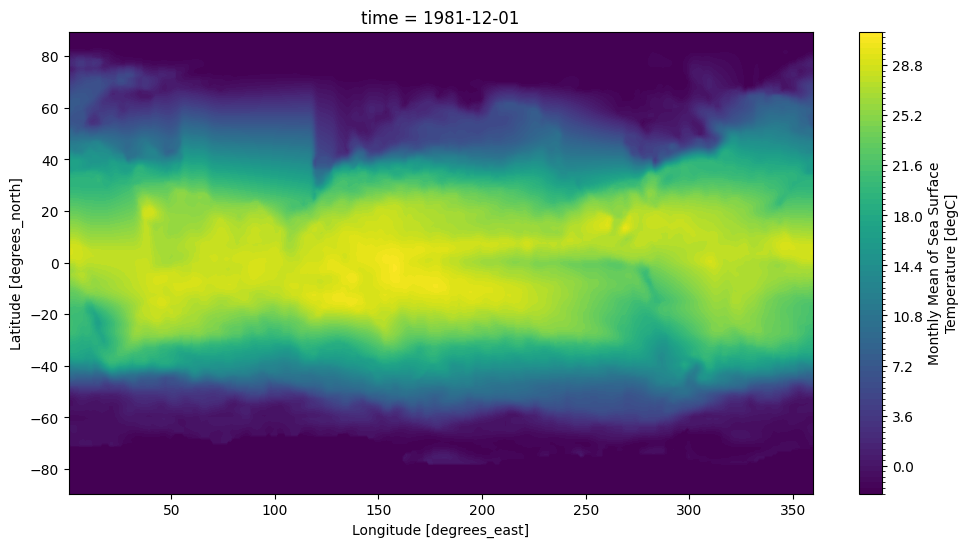

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
p = sst.isel(time=0).plot.contourf(ax=ax, levels=100, center=False)

## Mean Sea Level Pressure (MSLP)

In [71]:
file_mslp = 'mslp_coarse.nc'

ds_mslp = xr.open_dataset(Path(dir0, file_mslp))
mslp = ds_mslp['msl']

In [72]:
ds_mslp

<xarray.Dataset> Size: 138MB
Dimensions:    (time: 531, latitude: 181, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 724B 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-03-01
Data variables:
    msl        (time, latitude, longitude) float32 138MB ...
Attributes:
    Conventions:                 CF-1.6
    NCO:                         netCDF Operators version 4.9.1 (Homepage = h...
    title:                       ERA5 reanalysis
    data_type:                   1xmonthly fields analysis
    grid_resolution_in_degrees:  0.25
    source:                      credit: ECMWF, COPERNICUS Climate Change Ser...
    history:                     Thu Nov 30 14:28:43 2023: ncks -d longitude,...

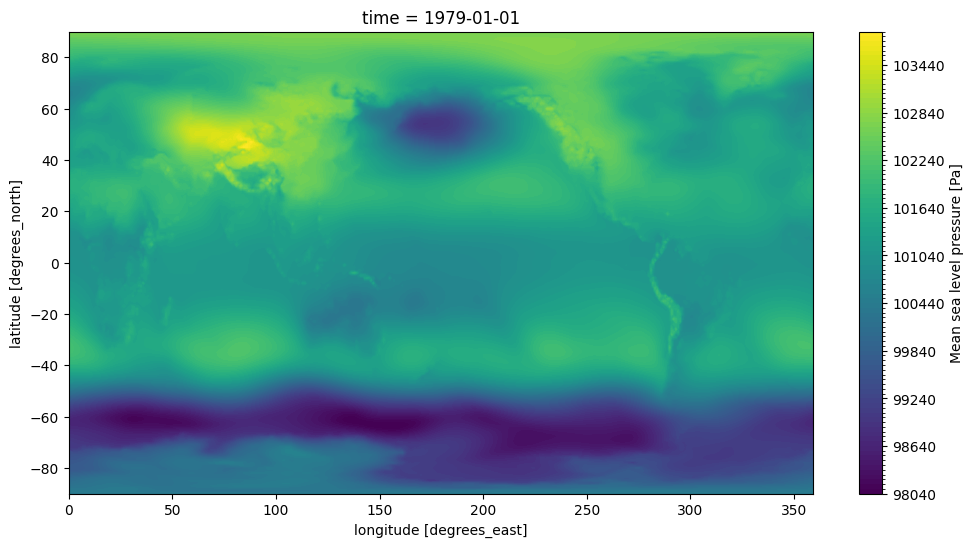

In [73]:
fig, ax = plt.subplots(figsize=(12, 6))
p = mslp.isel(time=0).plot.contourf(ax=ax, levels=100, center=False)

## Data Split

The available datasets are split at the beginning of the analysis into training, validation, and test periods. Adopting this strategy ensures that all preprocessing steps are consistent with the subsequent forecasting framework and prevents information leakage from future periods into the model training stage. By restricting the estimation of climatological means and dominant variability modes to the training period, the validation and test datasets remain fully independent.


In [74]:
train_slice = slice("1981-01", "2010-12")
val_slice   = slice("2011-01", "2015-12")
test_slice  = slice("2016-01", "2021-12") 

# Tropical Pacific coordinates
lat_tp = slice(20, -20)
lon_tp = slice(120, 280)

# SST anomalies (Tropical Pacific)
clim = ds_sst.sel(time=train_slice).groupby("time.month").mean("time")
sst_anom = ds_sst.groupby("time.month") - clim
sst_anom_tp = sst_anom.sel(lat=lat_tp, lon=lon_tp)
sst_tp = sst_anom_tp["sst"]

# MSLP anomalies (Tropical Pacific)
mslp_clim = ds_mslp.sel(time=train_slice).groupby('time.month').mean('time')
mslp_anom = ds_mslp.groupby('time.month') - mslp_clim
mslp_anom_tp = mslp_anom.sel(latitude=lat_tp, longitude=lon_tp)
mslp_tp = mslp_anom_tp['msl']

# EOF/PC (Empirical Orthogonal Function/Principal Component)

To reduce the dimensionality of the gridded climate datasets and isolate their dominant modes of variability, an Empirical Orthogonal Function (EOF) analysis is applied separately to the sea surface temperature (SST) and mean sea level pressure (MSLP) anomaly fields over the tropical Pacific.

For a given climate variable $X$, the anomaly field can be expressed as a linear combination of a limited number of orthogonal spatial patterns:

$$
X(x, y, t) = \sum_{k=1}^{K} \mathrm{PC}_k(t)\,\mathrm{EOF}_k(x, y)
$$

where:
- $\mathrm{EOF}_k(x, y)$ are the spatial EOF patterns representing the dominant modes of variability,
- $\mathrm{PC}_k(t)$ are the corresponding principal component (PC) time series describing the temporal evolution of each mode,
- $k$ denotes the EOF mode number, ordered by decreasing explained variance.

With this, we will be able to reduce the huge dataset into a few meaningful modes.


We select the Tropical Pacific region to be analysed as 20°N-20°S, 120°E-80°W:

<center><img alt="weather" src="images/tropical-pacific.png" width=600></center>

## SST anomaly (EOF/PC)

In [75]:
sst_train = sst_tp.sel(time=train_slice)
solver = Eof(sst_train)

# Spatial patterns (learned from train)
eof_sst = solver.eofs(neofs=5)

# Variance explained (train)
var_sst = solver.varianceFraction()

# Principal components (PCs)
pc_train_sst = solver.pcs(npcs=5)
pc_all_sst = solver.projectField(sst_tp, neofs=5)

### Variance Explained
To understand which modes are most relevant, we first examine the fraction of total SST-anomaly variance captured by each EOF. The variance explained plot highlights the dominance of the first modes.

The first 2 SST EOF modes explain 61.817% of the variance.
The first 10 SST EOF modes explain 81.777% of the variance.


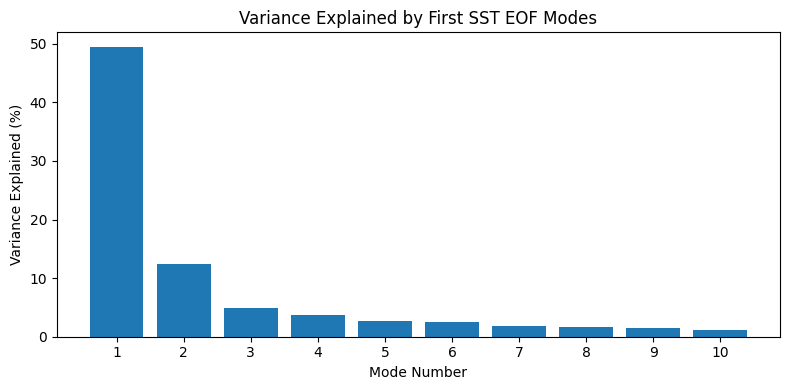

In [76]:
n_modes = min(10, len(var_sst))
var_sst10 = var_sst[:n_modes] * 100

print(f"The first 2 SST EOF modes explain {np.sum(var_sst10[:2]).item():.3f}% of the variance.")
print(f"The first {n_modes} SST EOF modes explain {np.sum(var_sst10).item():.3f}% of the variance.")

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(range(1, n_modes + 1), var_sst10)

ax.set_title("Variance Explained by First SST EOF Modes")
ax.set_xlabel("Mode Number")
ax.set_ylabel("Variance Explained (%)")
ax.set_xticks(range(1, n_modes + 1))

plt.tight_layout()
plt.show()

### Dominant modes of SST variability (EOF1 and EOF2)

The first two EOF modes together explain nearly 60% of the total variance in Tropical Pacific SST anomalies. 

* **EOF1** accounts for almost 50% of the variability and captures the classic ENSO pattern, with strong loadings across all Niño regions (1+2, 3, 3.4, and 4).
* **EOF2** explains about 11% of the variability and emphasizes changes in the Niño 1+2 area.

Higher order modes contribute less to the total variance and are not considered further here.

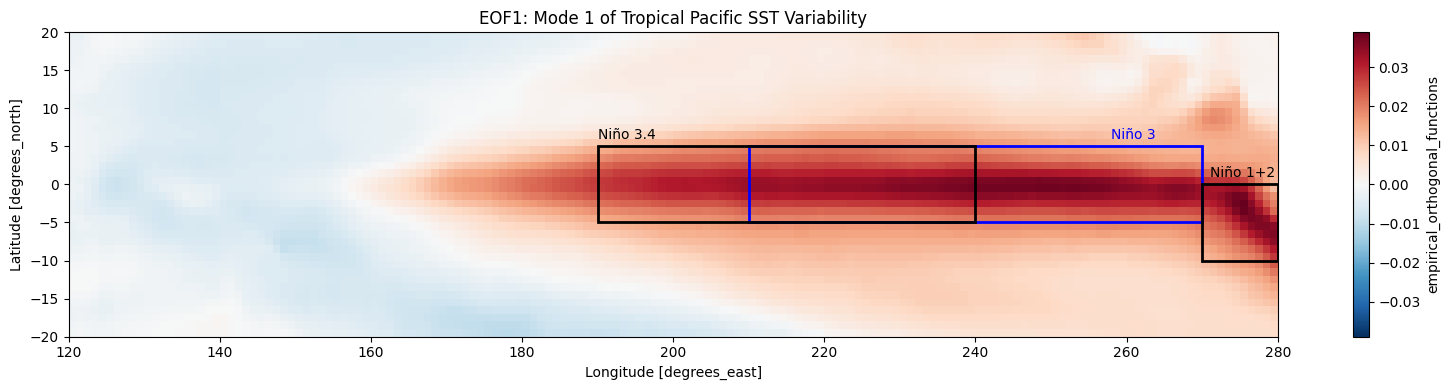

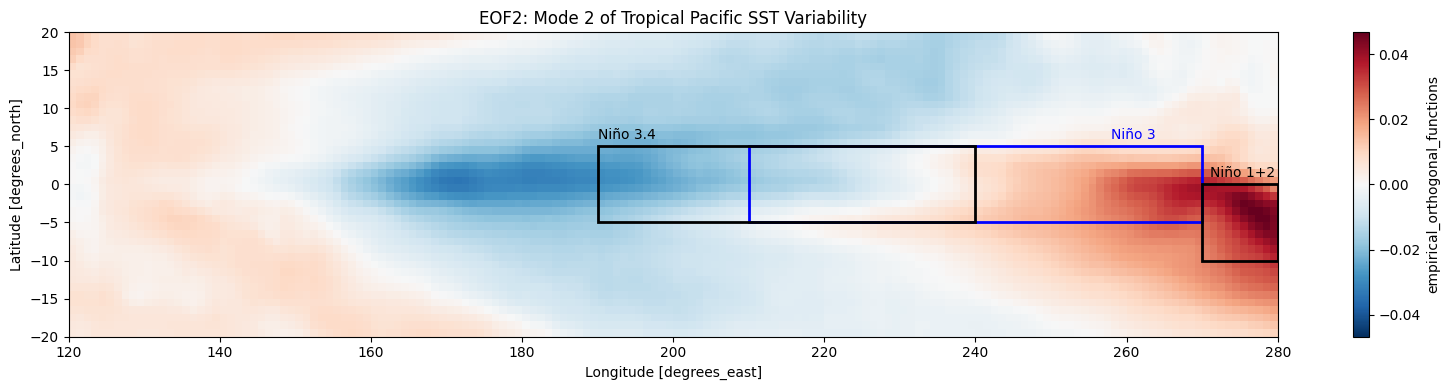

In [77]:
plot_modes_regions(eof_sst, modes=[0, 1], name='SST')

### Principal Components
The principal components describe how strongly each EOF mode is expressed over time. Plotting PC1 and PC2 allows us to see when the dominant SST variability patterns are active, highlighting periods associated with different types of ENSO behaviour.

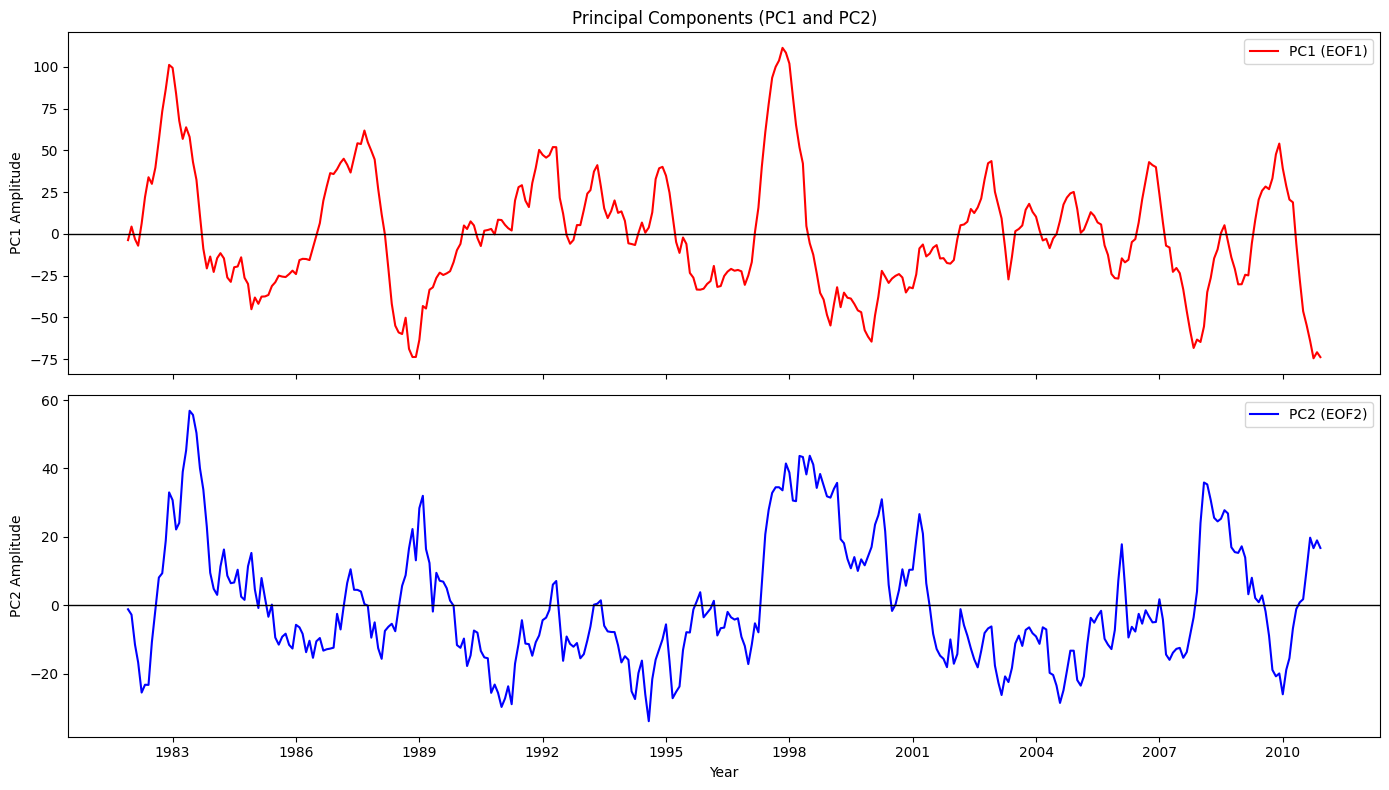

In [78]:
plot_pricipal_components(pc_train_sst)

#### Orthogonality (PC1 and PC2)
Because EOF modes are constructed to be uncorrelated in time, PC1 and PC2 should be orthogonal. The scatterplot and correlation value below confirm this property, showing that the two time series are statistically independent despite their spatial patterns overlapping.

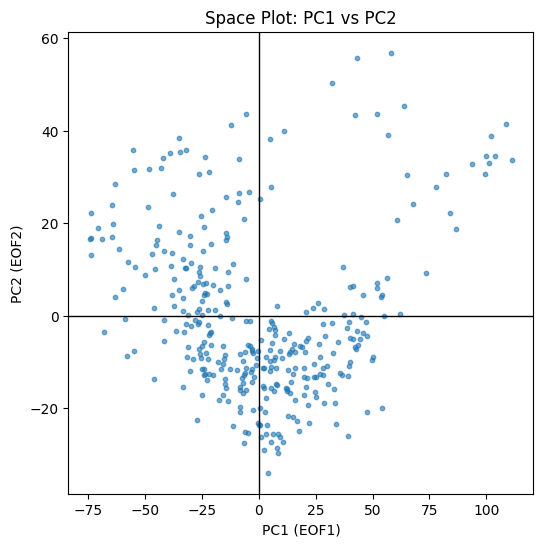

In [79]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(pc_train_sst[:,0], pc_train_sst[:,1], s=10, alpha=0.6)
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

ax.set_xlabel("PC1 (EOF1)")
ax.set_ylabel("PC2 (EOF2)")
ax.set_title("Space Plot: PC1 vs PC2")

plt.show()

In [80]:
correlation = np.round(np.corrcoef(pc_train_sst[:,0], pc_train_sst[:,1])[0,1],7)
print(f'Correlation between PC1 and PC2: {correlation}')

Correlation between PC1 and PC2: 0.0


## MLSP (EOF/PC)

In [81]:
mslp_train = mslp_tp.sel(time=train_slice)
solver = Eof(mslp_train)

# Spatial patterns (learned from train)
eof_mslp = solver.eofs(neofs=5)

# Variance explained (train)
var_mslp = solver.varianceFraction()

# Principal components (PCs)
pc_train_mslp = solver.pcs(npcs=5)
pc_all_mslp = solver.projectField(mslp_tp, neofs=5)

### Variance Explained

The first 2 MLSP EOF modes explain 66.365% of the variance.
The first 10 MSLP EOF modes explain 91.800% of the variance.


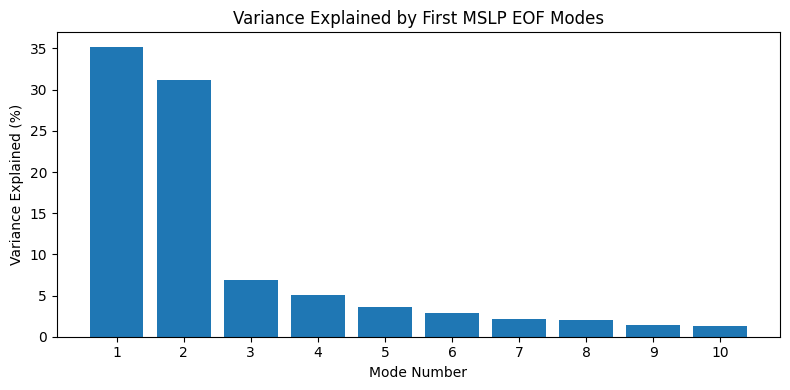

In [82]:
n_modes = min(10, len(var_mslp))
sst_var10 = var_mslp[:n_modes] * 100

print(f"The first 2 MLSP EOF modes explain {np.sum(sst_var10[:2]).item():.3f}% of the variance.")
print(f"The first {n_modes} MSLP EOF modes explain {np.sum(sst_var10).item():.3f}% of the variance.")

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(range(1, n_modes + 1), sst_var10)

ax.set_title("Variance Explained by First MSLP EOF Modes")
ax.set_xlabel("Mode Number")
ax.set_ylabel("Variance Explained (%)")
ax.set_xticks(range(1, n_modes + 1))

plt.tight_layout()
plt.show()

### Dominant modes of MLSP variability (EOF1 and EOF2)

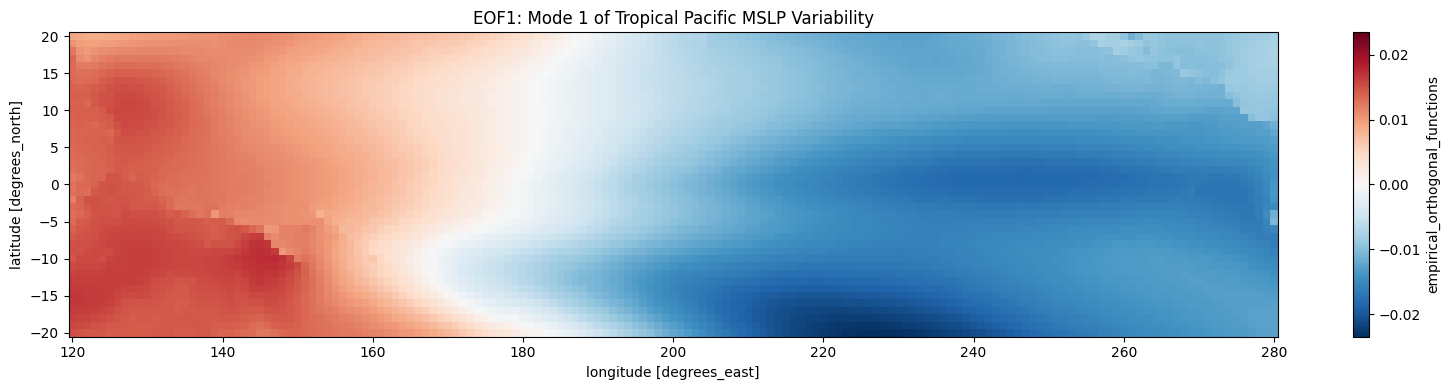

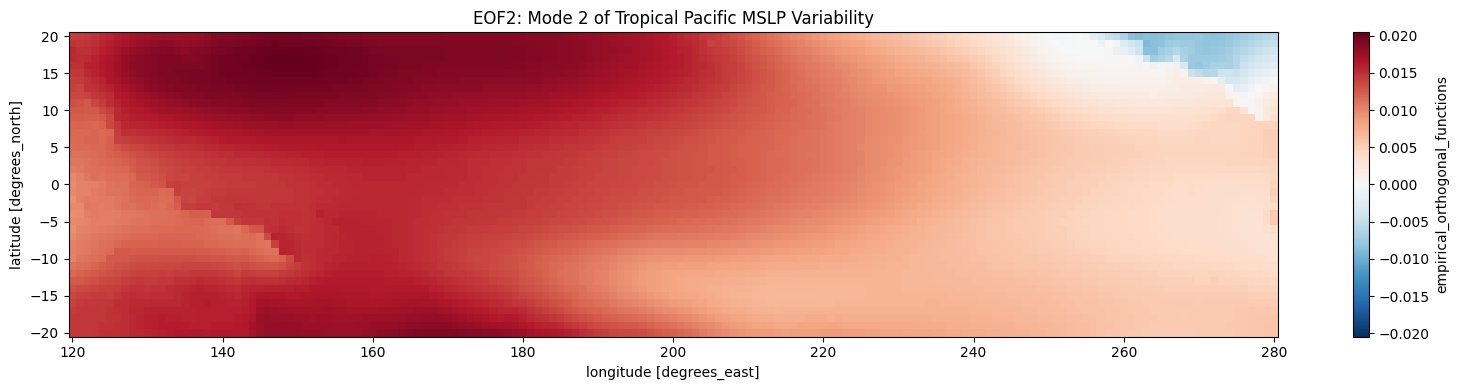

In [83]:
plot_modes_regions(eof_mslp, modes=[0, 1], name='MSLP')

### Principal Components

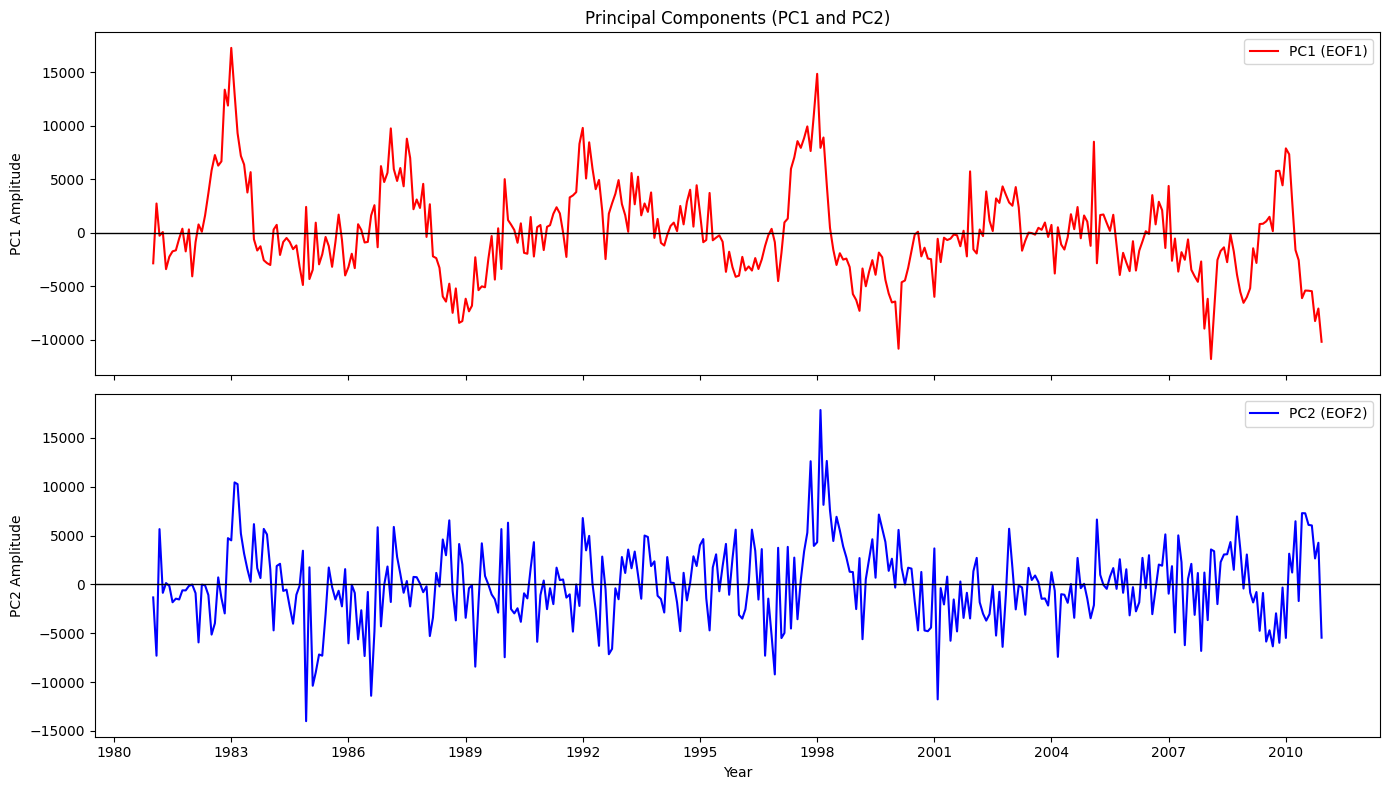

In [84]:
plot_pricipal_components(pc_train_mslp)

# Characterizing El niño

In red: Niño 3 region (5°N-5°S, 90°-150°W)

In blue: Niño 3.4 region (5°N–5°S, 120°–170°W)

<center><img alt="weather" src="images/nino3-nino34.png" width=600></center>

* **Definition:** According to the National Center for Atmospheric Research (NCAR), an El Niño event occurs when the 5-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region (5° N-5° S, 120°-170° W) remains above +0.4 °C for at least six consecutive months.

Given that we have nearly 40 years of data (from December 1981 to June 2021), we will use the first 30 years as the base period climatology, that is, the set of average temperatures for each of the 12 calendar months. Using this baseline, we will then compute SST anomalies for the entire time span.

1. Calculate monthly SST anomalies averaged for the areas known as "Niño 3" and "Niño 3.4".
2. Find periods during which 5-month running means of the monthly SST anomalies in the above mentioned areas are +0.5°C (Niño 3), +0.4°C (Niño 3.4) or more for at least six consecutive months.

In [85]:
nino_3   = dict(lat=slice(5, -5), lon=slice(210, 270))   # Niño 3 (150°W–90°W)
nino_34  = dict(lat=slice(5, -5), lon=slice(190, 240))   # Niño 3.4 (170°W–120°W)

sst_nino_3  = sst.sel(**nino_3).mean(dim=["lat", "lon"])
sst_nino_34 = sst.sel(**nino_34).mean(dim=["lat", "lon"])

In [86]:
nino_3_30y = sst_nino_3.sel(time=slice("1981-12", "2011-12"))
climatology_3 = nino_3_30y.groupby("time.month").mean("time")
nino_3_anom = sst_nino_3.groupby("time.month") - climatology_3

nino_34_30y = sst_nino_34.sel(time=slice("1981-12", "2011-12"))
climatology_34 = nino_34_30y.groupby("time.month").mean("time")
nino_34_anom = sst_nino_34.groupby("time.month") - climatology_34

## El Niño 3

### Monthly average SST

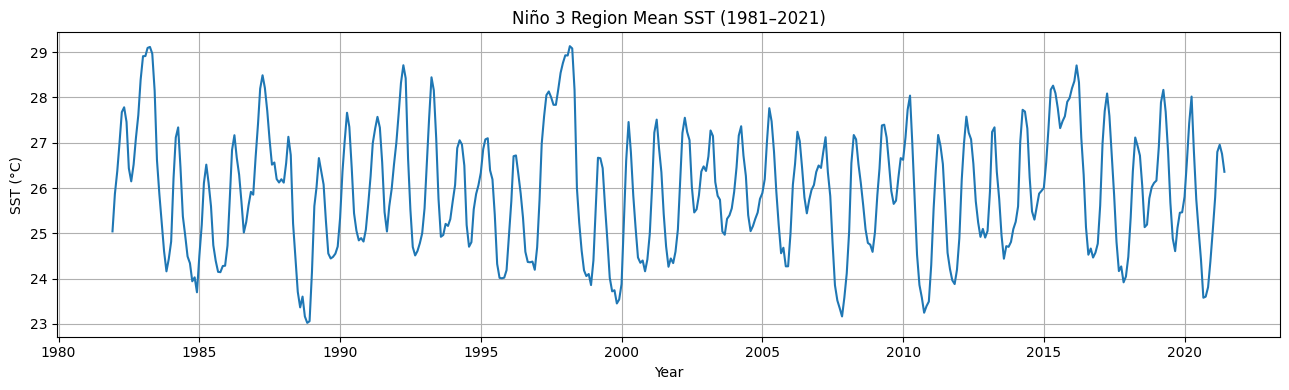

In [87]:
plt.figure(figsize=(13, 4))
plt.plot(sst_nino_3['time'], sst_nino_3)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3 Region Mean SST (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.tight_layout()
plt.show()

### Trend Analysis (Linear regression)

Here, we numerically verify that there is no linear trend in the sea surface temperature time series for the Niño 3 region.

To do this, we run a simple linear regression:

$$
SST(t) = \beta_0 + \beta_1 t + \epsilon
$$

Then, we analyse the slope $\beta_1$:

- The trend estimate $\beta = -0.0015$ °C/year is almost zero.
- The p-value $p = 0.778$ is extremely not significant.
- The confidence interval $[-0.012\quad0.009]$ includes zero.
- The coefficient of determination $R^2 = 0.000$ shows the model explains basically none of the variance in the data.

With this, we conclude that the data behaves like an ENSO-dominated time series, without a long-term trend.

In [88]:
years = sst_nino_3['time'].dt.year + (sst_nino_3['time'].dt.month - 1)/12
y = sst_nino_3.values
X = sm.add_constant(years)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07922
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.778
Time:                        21:51:14   Log-Likelihood:                -814.88
No. Observations:                 475   AIC:                             1634.
Df Residuals:                     473   BIC:                             1642.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9828     10.836      2.675      0.0

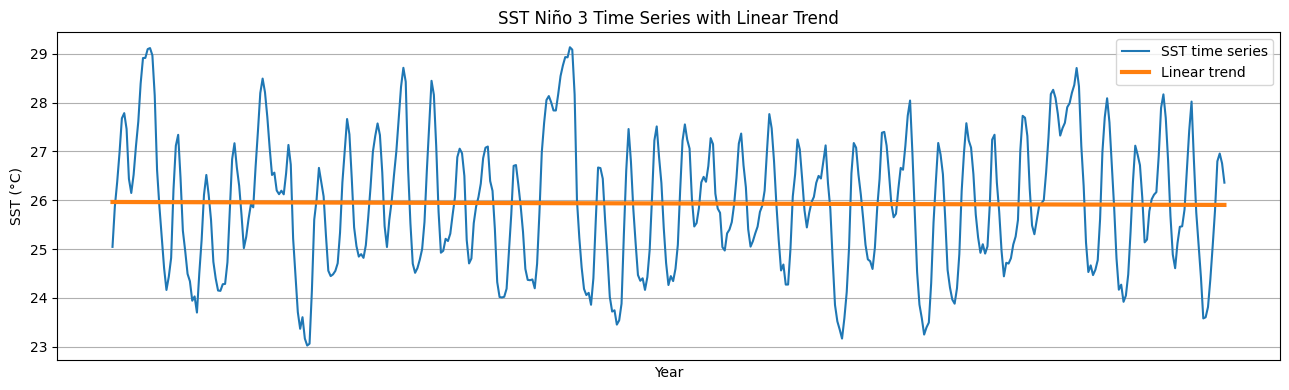

In [89]:
y_pred = model.predict(X)

plt.figure(figsize=(13, 4))
plt.plot(years, y, label='SST time series')
plt.plot(years, y_pred, label='Linear trend', linewidth=3)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('SST Niño 3 Time Series with Linear Trend')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.legend()
plt.tight_layout()
plt.show()

### SST Anomalies

In [90]:
nino_3_5mo = nino_3_anom.rolling(time=5, center=True).mean()
anom = nino_3_5mo.to_series()

# El Niño and La Niña conditions
is_elnino = anom > 0.5
is_lanina = anom < -0.5

elnino_periods_nino3 = find_events(is_elnino)
lanina_periods_nino3 = find_events(is_lanina)

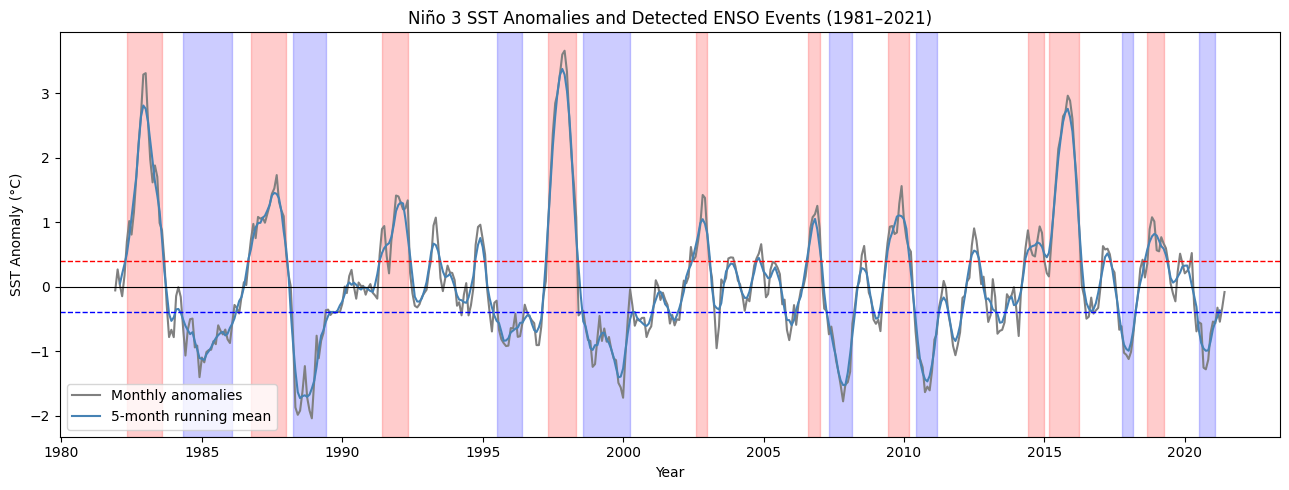

In [91]:
plt.figure(figsize=(13,5))
plt.plot(anom.index, nino_3_anom, color='gray', label='Monthly anomalies')
plt.plot(anom.index, anom, color='steelblue', label='5-month running mean')

plt.axhline(0.4, color='red', linestyle='--', linewidth=1)
plt.axhline(-0.4, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=0.8)

# Shade El Niño and La Niña events
for start, end in elnino_periods_nino3:
    plt.axvspan(start, end, color='red', alpha=0.2)
for start, end in lanina_periods_nino3:
    plt.axvspan(start, end, color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3 SST Anomalies and Detected ENSO Events (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.tight_layout()
plt.show()

We define a dataframe with flags that refer to the phase of each month, classified from the analysis of the Niño 3 region:

| Flag | ENSO Phase |
| :- | -: |
| **2** | El Niño |
| **1** | La Niña |
| **0** | Neither |

In [92]:
df_nino3 = pd.DataFrame({
    'timestamp': anom.index,
    'mean_SST': sst_nino_3,
    'monthly_anom': nino_3_anom,
    '5mo_running_anom': anom,
    'flag': 0, #placeholder
})

# flag el nino and la nina periods
for start, end in elnino_periods_nino3:
    df_nino3.loc[(df_nino3.index >= start) & (df_nino3.index <= end), "flag"] = 2
for start, end in lanina_periods_nino3:
    df_nino3.loc[(df_nino3.index >= start) & (df_nino3.index <= end), "flag"] = 1

df_nino3.head()

timestamp   mean_SST  monthly_anom  5mo_running_anom  flag
time                                                                  
1981-12-01 1981-12-01  25.043583     -0.057739               NaN     0
1982-01-01 1982-01-01  25.868416      0.267347               NaN     0
1982-02-01 1982-02-01  26.374184      0.013208          0.050568     0
1982-03-01 1982-03-01  26.974382     -0.147890          0.201229     0
1982-04-01 1982-04-01  27.675814      0.177916          0.351203     0

## El Niño 3.4

### Monthly average SST

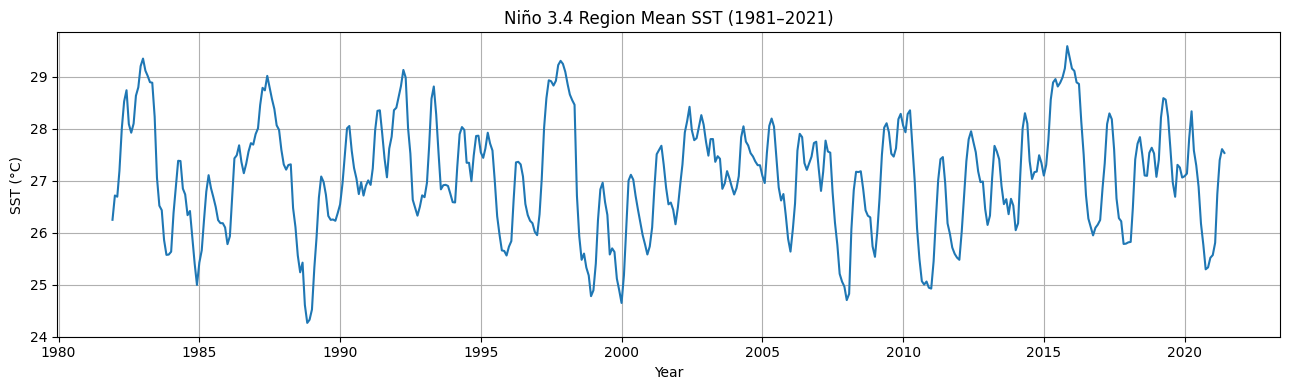

In [93]:
plt.figure(figsize=(13, 4))
plt.plot(sst_nino_34['time'], sst_nino_34)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3.4 Region Mean SST (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.tight_layout()
plt.show()

### Trend analysis (Linear Regression)

Here, we numerically verify that there is no linear trend in the sea surface temperature time series for the Niño 3.4 region.

To do this, we run a simple linear regression:

$$
SST(t) = \beta_0 + \beta_1 t + \epsilon
$$

Then, we analyse the slope $\beta_1$:

- The trend estimate $\beta = -0.0009$ °C/year is almost zero.
- The p-value $p = 0.826$ is extremely not significant.
- The confidence interval $[-0.009\quad0.007]$ includes zero.
- The coefficient of determination $R^2 = 0.000$ shows the model explains basically none of the variance in the data.

With this, we conclude that the data for this region also behaves like an ENSO-dominated time series, without a long-term trend.

In [94]:
years = sst_nino_34['time'].dt.year + (sst_nino_34['time'].dt.month - 1)/12
y = sst_nino_34.values
X = sm.add_constant(years)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04819
Date:                Fri, 12 Dec 2025   Prob (F-statistic):              0.826
Time:                        21:51:16   Log-Likelihood:                -701.57
No. Observations:                 475   AIC:                             1407.
Df Residuals:                     473   BIC:                             1415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9467      8.536      3.391      0.0

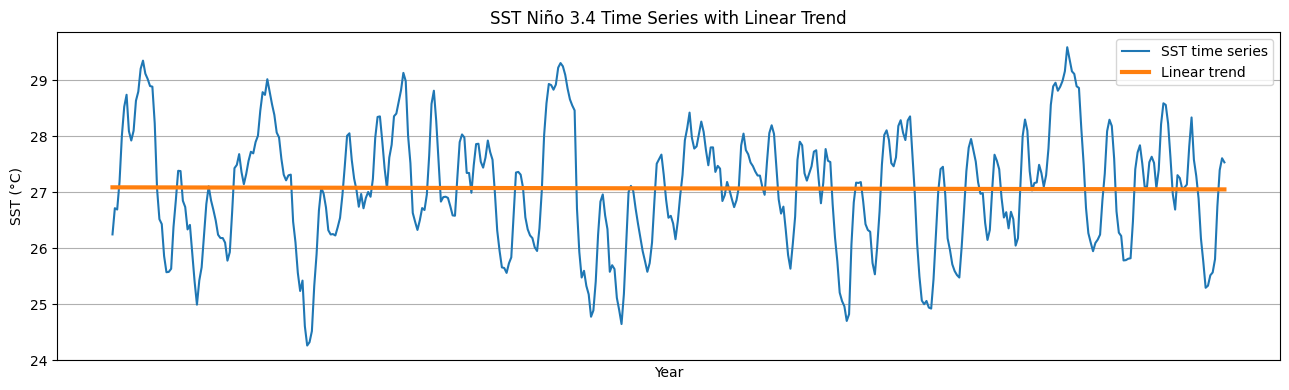

In [95]:
y_pred = model.predict(X)

plt.figure(figsize=(13, 4))
plt.plot(years, y, label='SST time series')
plt.plot(years, y_pred, label='Linear trend', linewidth=3)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('SST Niño 3.4 Time Series with Linear Trend')
plt.xlabel('Year')
plt.ylabel('SST (°C)')
plt.legend()
plt.tight_layout()
plt.show()

### SST Anomalies

In [96]:
nino_34_5mo = nino_34_anom.rolling(time=5, center=True).mean()
anom = nino_34_5mo.to_series()

# El Niño and La Niña conditions
is_elnino = anom > 0.4
is_lanina = anom < -0.4

elnino_periods_nino34 = find_events(is_elnino)
lanina_periods_nino34 = find_events(is_lanina)

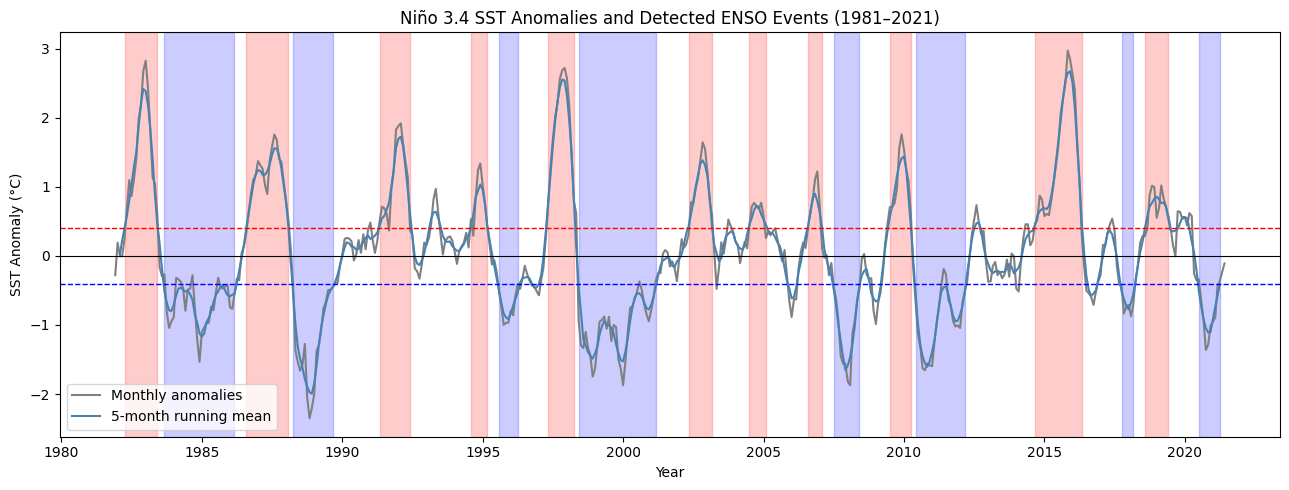

In [97]:
plt.figure(figsize=(13,5))
plt.plot(anom.index, nino_34_anom, color='gray', label='Monthly anomalies')
plt.plot(anom.index, anom, color='steelblue', label='5-month running mean')

plt.axhline(0.4, color='red', linestyle='--', linewidth=1)
plt.axhline(-0.4, color='blue', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linewidth=0.8)

# Shade El Niño and La Niña events
for start, end in elnino_periods_nino34:
    plt.axvspan(start, end, color='red', alpha=0.2)
for start, end in lanina_periods_nino34:
    plt.axvspan(start, end, color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Niño 3.4 SST Anomalies and Detected ENSO Events (1981–2021)')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.tight_layout()
plt.show()

We define a dataframe with flags that refer to the phase of each month, classified from the analysis of the Niño 3.4 region:

| Flag | ENSO Phase |
| :- | -: |
| **2** | El Niño |
| **1** | La Niña |
| **0** | Neither |

In [98]:
df_nino34 = pd.DataFrame({
    'timestamp': anom.index,
    'mean_SST': sst_nino_34,
    'monthly_anom': nino_34_anom,
    '5mo_running_anom': anom,
    'flag': 0, #placeholder
})

# flag el nino and la nina periods
for start, end in elnino_periods_nino34:
    df_nino34.loc[(df_nino34.index >= start) & (df_nino34.index <= end), "flag"] = 2
for start, end in lanina_periods_nino34:
    df_nino34.loc[(df_nino34.index >= start) & (df_nino34.index <= end), "flag"] = 1

## Principal Components (SST)

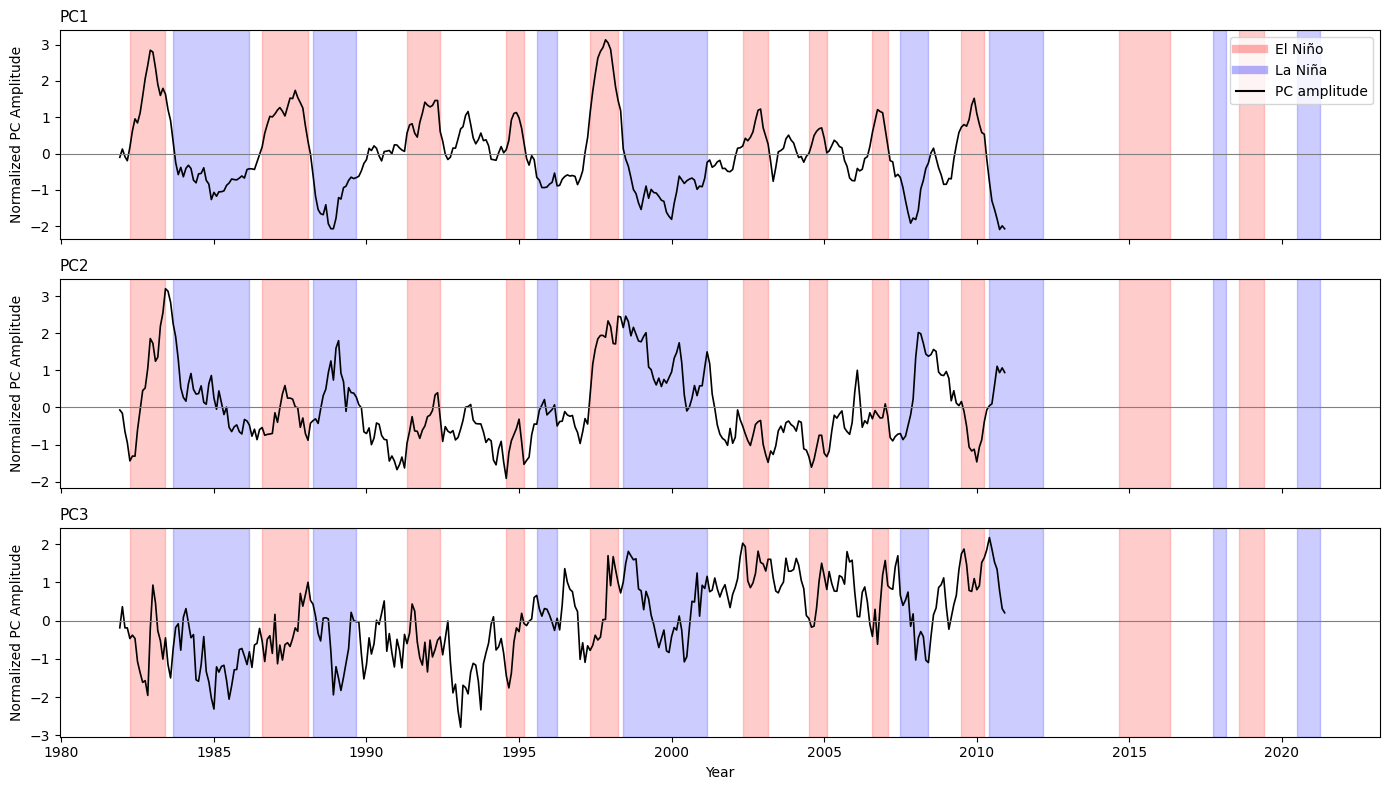

In [99]:
time = pc_train_sst['time'].values
pc_norm = (pc_train_sst - pc_train_sst.mean(dim='time')) / pc_train_sst.std(dim='time')

pcs_to_plot = [0, 1, 2]
titles = ["PC1","PC2","PC3"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)

for i, ax in zip(pcs_to_plot, axes):

    ax.plot(time, pc_norm[:, i], color="black", linewidth=1.2,label=f"PC{i+1}")

    ax.axhline(0, color="gray", linewidth=0.8)

    for start, end in elnino_periods_nino34:
        ax.axvspan(start, end, color="red", alpha=0.2)
    for start, end in lanina_periods_nino34:
        ax.axvspan(start, end, color="blue", alpha=0.2)

    ax.set_ylabel("Normalized PC Amplitude")
    ax.set_title(titles[i], loc="left", fontsize=11)

axes[-1].xaxis.set_major_locator(mdates.YearLocator(5))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axes[-1].set_xlabel("Year")

handles = [
    plt.Line2D([0], [0], color="red", lw=6, alpha=0.3, label="El Niño"),
    plt.Line2D([0], [0], color="blue", lw=6, alpha=0.3, label="La Niña"),
    plt.Line2D([0], [0], color="black", lw=1.5, label="PC amplitude"),
]
axes[0].legend(handles=handles, loc="upper right")

plt.tight_layout()
plt.show()

* PC1 exhibits a strong correspondence with Niño-3.4 defined ENSO phases, with positive (negative) amplitudes during El Niño (La Niña) conditions. This confirms that the leading EOF mode captures the canonical ENSO related SST variability.
* PC2 shows a weaker direct correspondence with ENSO phases.
* PC3 does not exhibit a clear phase locking with ENSO events.

## Southern Oscillation Index (SOI)

The Southern Oscillation Index (SOI) is a measure of the atmospheric part of ENSO — the pressure difference between the western and eastern tropical Pacific. It gives an indication of the development and intensity of El Niño or La Niña events in the Pacific Ocean. 

- Sustained negative values of the SOI lower than $−7$ (low pressure in the east) often indicate **El Niño** episodes.
- Sustained positive values of the SOI greater than $+7$ (low pressure in the west) are typical of a **La Niña** episode.

Here we use the Troup method for calculating the SOI, which takes the standardised anomaly of the Means Sea Level Pressure difference between Tahiti and Darwin stations. The multiplication by 10 is a convention which makes the SOI value be quoted as a whole number ranging from about –35 to about +35. We use the 30-year base period from 1981-2011. [3]

$$
SOI = 10 \frac{P_{\text{diff}} - P_{\text{diff}_{\text{av}}}}{\sigma_{P_{\text{diff}}}}
$$
where:

- $P_{\text{diff}} = \text{MSLP}_\text{Tahiti} - \text{MSLP}_\text{Darwin}$
- $P_{\text{diff}_{\text{av}}} = $ long term average of $P_{\text{diff}}$ for the month in question
- $ \sigma_{P_{\text{diff}}} = $ long term standard deviation of $P_{\text{diff}}$ for the month in question

<center><img alt="weather" src="images/darwin-tahiti.png" width=850></center>

In [100]:
# compute global mslp monthly anomalies based on 30-year climatology (useful later)
clim = ds_mslp.sel(time=slice('1981-01','2010-12')).groupby('time.month').mean('time')

mslp_anom = ds_mslp.groupby('time.month') - clim

In [101]:
# Extract grid cells near Tahiti and Darwin
tahiti = mslp.sel(latitude=-17.5, longitude=210, method='nearest')
darwin = mslp.sel(latitude=-12.5, longitude=131, method='nearest')

p_diff = tahiti - darwin

In [102]:
# get statistics from 30-year base period
p_diff_30y = p_diff.sel(time=slice("1981-12", "2011-12"))

p_diff_av = p_diff_30y.groupby("time.month").mean("time")
p_diff_std = p_diff_30y.groupby("time.month").std("time")

In [103]:
# compute SOI time series for the whole period
month_index = p_diff["time.month"]

soi = 10 * (
    (p_diff - p_diff_av.sel(month=month_index))
    / p_diff_std.sel(month=month_index)
)

In [104]:
# find anomalies
soi_3mo = soi.rolling(time=3, center=True).mean()

soi = soi.to_series()
soi_3mo = soi_3mo.to_series()

negative = soi_3mo < -7
positive = soi_3mo > 7

soi_neg_periods = find_events(negative) # indicate el nino
soi_pos_periods = find_events(positive) # indicate la nina

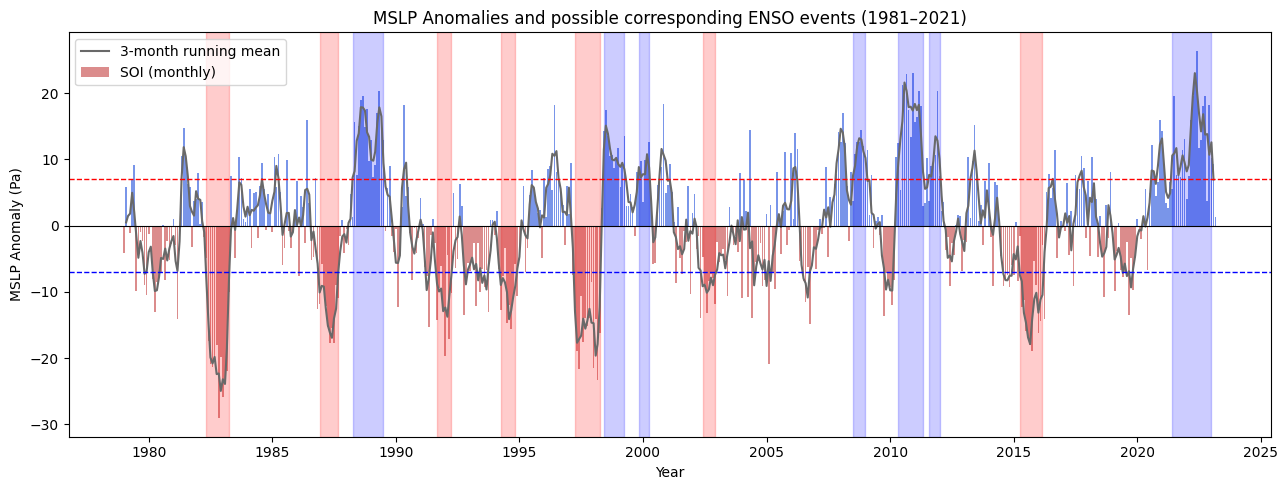

In [105]:
plt.figure(figsize=(13,5))

bar_colors = ['royalblue' if v >= 0 else 'indianred' for v in soi.values]

plt.bar(soi.index, soi.values, width=25, color=bar_colors, alpha=0.7, label='SOI (monthly)')

plt.plot(soi.index, soi_3mo, color='dimgray', label='3-month running mean')

plt.axhline(7,  color='red',  linestyle='--', linewidth=1)
plt.axhline(-7, color='blue', linestyle='--', linewidth=1)
plt.axhline(0,  color='black', linewidth=0.8)

for start, end in soi_neg_periods:
    plt.axvspan(start, end, color='red', alpha=0.2)
for start, end in soi_pos_periods:
    plt.axvspan(start, end, color='blue', alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('MSLP Anomalies and possible corresponding ENSO events (1981–2021)')
plt.xlabel('Year')
plt.ylabel('MSLP Anomaly (Pa)')
plt.legend()
plt.tight_layout()
plt.show()


In [106]:
df_ninoSOI = pd.DataFrame({
    'timestamp': soi.index,
    'tahiti-darwin': p_diff,
    'soi': soi,
    '3mo_running_anom': soi_3mo,
    'flag': 0, #placeholder
})

# flag el nino and la nina periods
for start, end in soi_neg_periods:
    df_ninoSOI.loc[(df_ninoSOI.index >= start) & (df_ninoSOI.index <= end), "flag"] = 2
for start, end in soi_pos_periods:
    df_ninoSOI.loc[(df_ninoSOI.index >= start) & (df_ninoSOI.index <= end), "flag"] = 1

df_ninoSOI.head()

timestamp  tahiti-darwin       soi  3mo_running_anom  flag
time                                                                  
1979-01-01 1979-01-01         364.50 -4.067598               NaN     0
1979-02-01 1979-02-01         603.25  5.797638          0.492466     0
1979-03-01 1979-03-01         341.50 -0.252642          1.466050     0
1979-04-01 1979-04-01         194.75 -1.146847          1.832598     0
1979-05-01 1979-05-01         226.00  6.897282          4.970255     0

## Principal Components (MSLP)

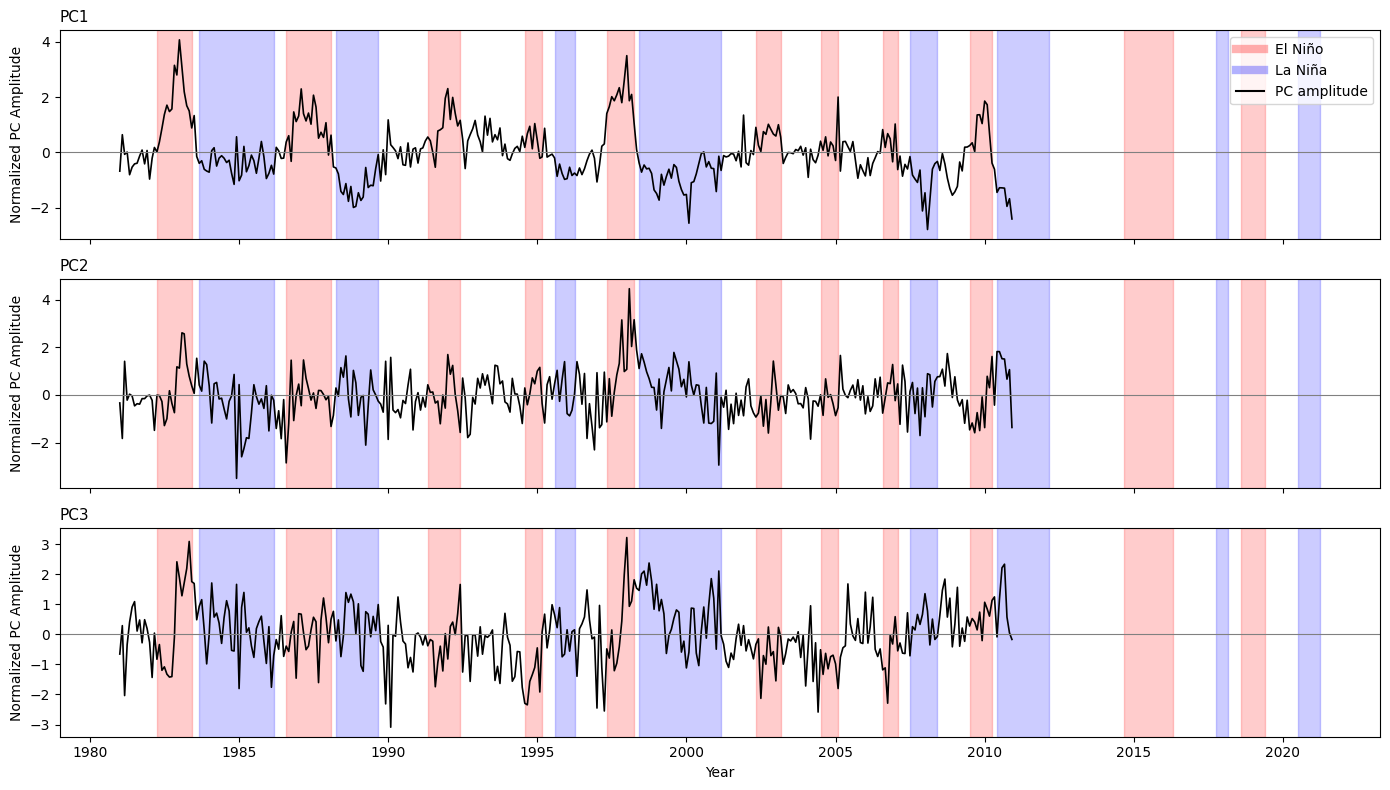

In [107]:
time = pc_train_mslp['time'].values
pc_norm = (pc_train_mslp - pc_train_mslp.mean(dim='time')) / pc_train_mslp.std(dim='time')

pcs_to_plot = [0, 1, 2]
titles = ["PC1","PC2","PC3"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8), sharex=True)

for i, ax in zip(pcs_to_plot, axes):

    ax.plot(time, pc_norm[:, i], color="black", linewidth=1.2,label=f"PC{i+1}")

    ax.axhline(0, color="gray", linewidth=0.8)

    for start, end in elnino_periods_nino34:
        ax.axvspan(start, end, color="red", alpha=0.2)
    for start, end in lanina_periods_nino34:
        ax.axvspan(start, end, color="blue", alpha=0.2)

    ax.set_ylabel("Normalized PC Amplitude")
    ax.set_title(titles[i], loc="left", fontsize=11)

axes[-1].xaxis.set_major_locator(mdates.YearLocator(5))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axes[-1].set_xlabel("Year")

handles = [
    plt.Line2D([0], [0], color="red", lw=6, alpha=0.3, label="El Niño"),
    plt.Line2D([0], [0], color="blue", lw=6, alpha=0.3, label="La Niña"),
    plt.Line2D([0], [0], color="black", lw=1.5, label="PC amplitude"),
]
axes[0].legend(handles=handles, loc="upper right")

plt.tight_layout()
plt.show()

* PC1 shows a clear link with Niño-3.4 ENSO phases, with opposite signs during El Niño and La Niña periods. This suggests that the leading MSLP mode is related to the atmospheric component of ENSO and is consistent with the Southern Oscillation.
* PC2 has a weaker and less consistent relationship with ENSO, with larger variations during some events and transition phases, indicating a secondary influence on ENSO-related atmospheric variability.
* PC3 does not show a clear or consistent relationship with ENSO phases and likely represents background or shorter-term atmospheric variability over the tropical Pacific.

# Exploratory Analysis

## Autocorrelation (ACF)

We compute the autocorrelation using the SST anomalies to remove the mean seasonal cycle and isolate ENSO variability. Both indices show a strong positive autocorrelation during the first 6 months, meaning the anomalies persist over this period. Around lag 9, the correlation drops to near zero, indicating a loss of memory. 

The grey shading represents the 95% confidence interval: values outside this region are statistically significant and not due to random noise. The significant negative correlations between lags 21–28 suggest an opposite-phase tendency, where warm anomalies are often followed by cooler anomalies about two years later.

### Niño 3

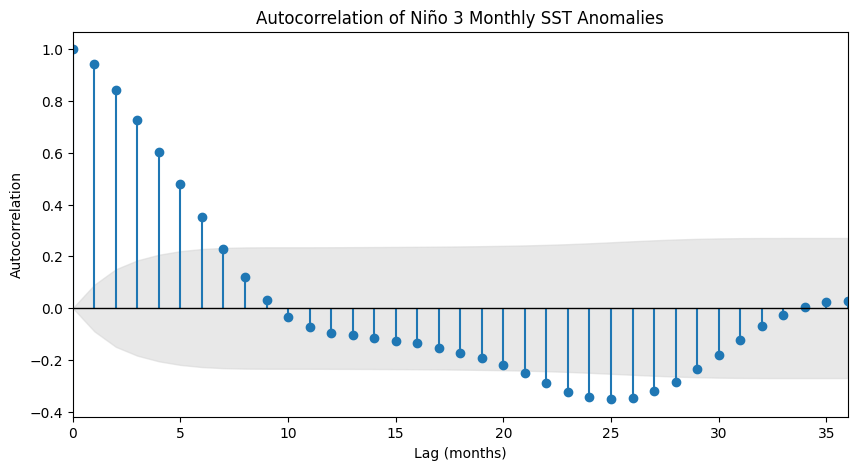

In [108]:
nlags = 36
plot_acf(df_nino3, nlags, region='Niño 3')

### Niño 3.4

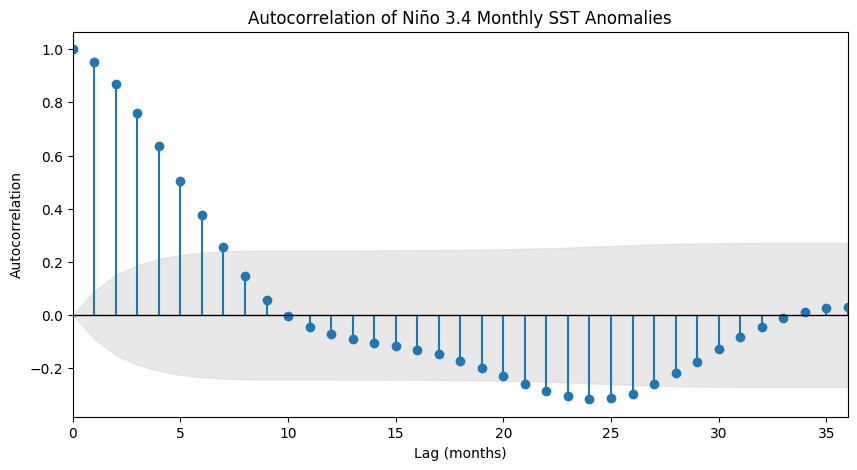

In [109]:
nlags = 36
plot_acf(df_nino34, nlags, region='Niño 3.4')

## Lag correlation: between indeces

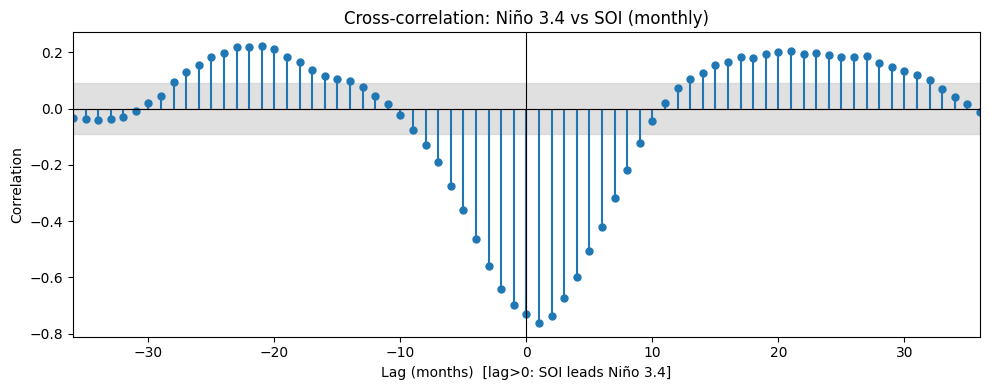

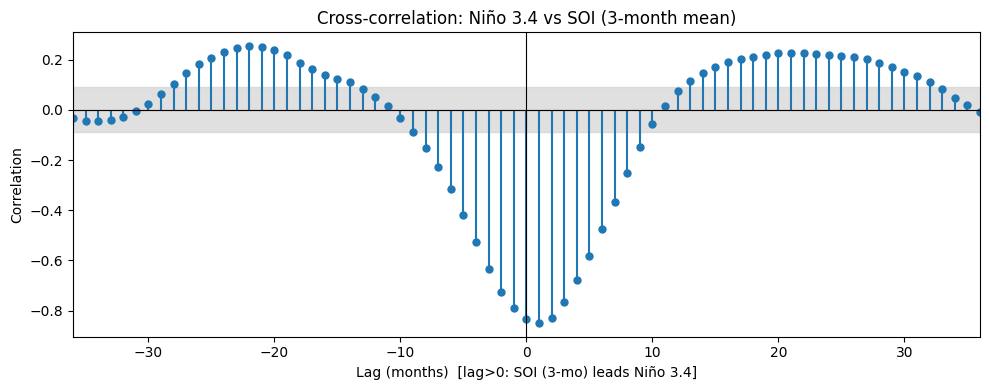

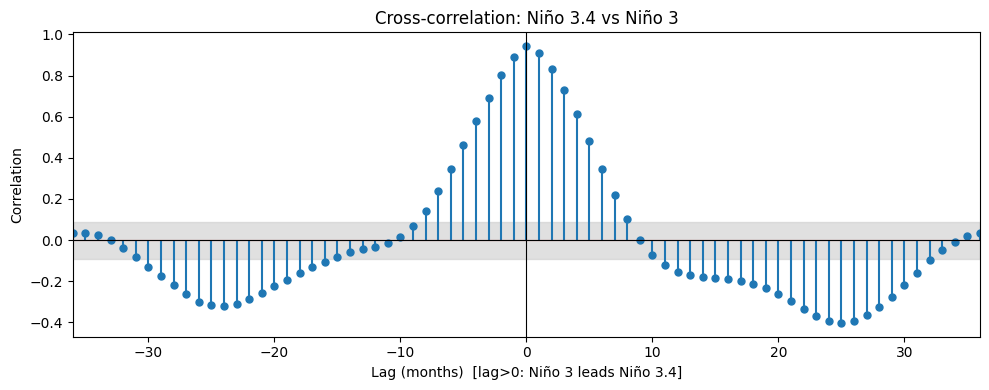

In [110]:
nlags = 36

s_nino_34_anom = nino_34_anom.to_series()
s_nino_3_anom = nino_3_anom.to_series()

# Niño3.4 vs SOI (monthly)
lags, r = plot_ccf(s_nino_34_anom, soi, nlags=nlags, xname="Niño 3.4", yname="SOI",
         title="Cross-correlation: Niño 3.4 vs SOI (monthly)")

# Niño3.4 vs SOI (3-month mean)
lags, r = plot_ccf(s_nino_34_anom, soi_3mo, nlags=nlags, xname="Niño 3.4", yname="SOI (3-mo)",
         title="Cross-correlation: Niño 3.4 vs SOI (3-month mean)")

# Niño3.4 vs Niño3
lags, r = plot_ccf(s_nino_34_anom, s_nino_3_anom, nlags=nlags, xname="Niño 3.4", yname="Niño 3",
         title="Cross-correlation: Niño 3.4 vs Niño 3")


## Lag correlation: spatial analyses

### Global SST anomalies vs. Niño 3.4

In [111]:
max_lag = 12
lag_corr = []

for lag in range(max_lag+1):
    n34_shifted = nino_34_anom.shift(time=-lag)
    corr = xr.corr(sst_anom['sst'], n34_shifted, dim='time')
    lag_corr.append(corr)

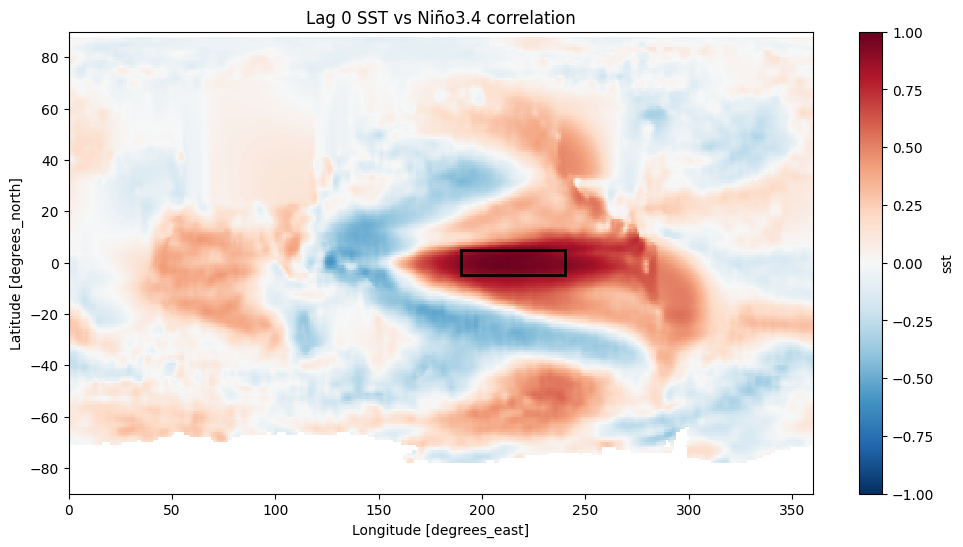

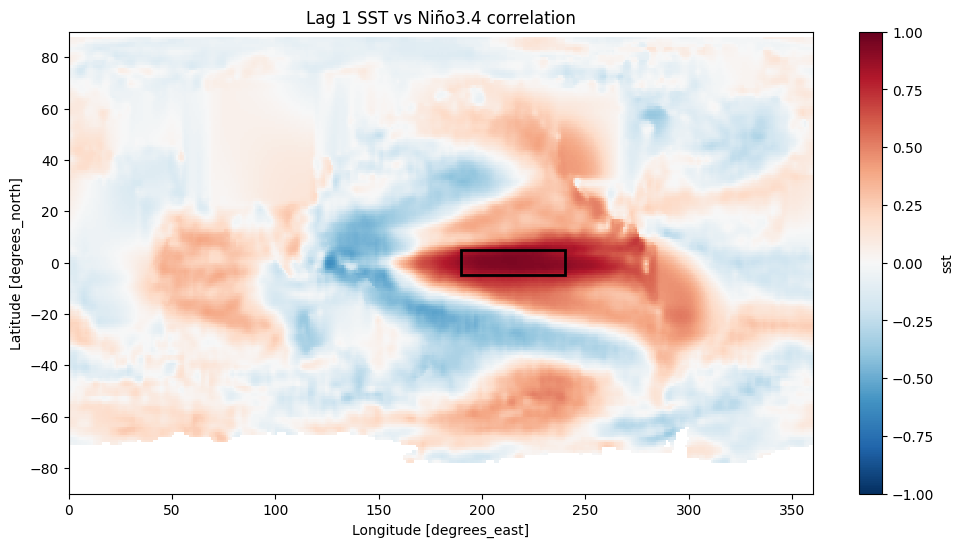

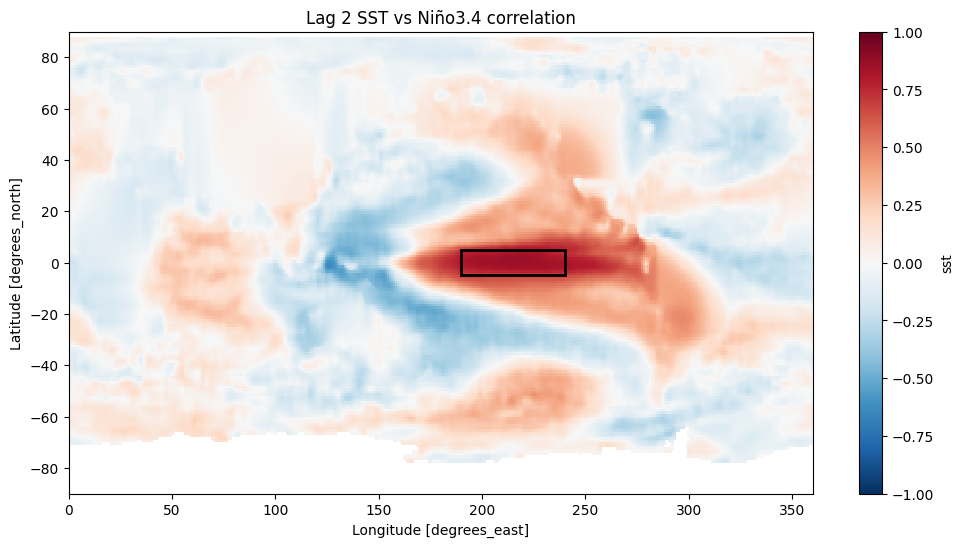

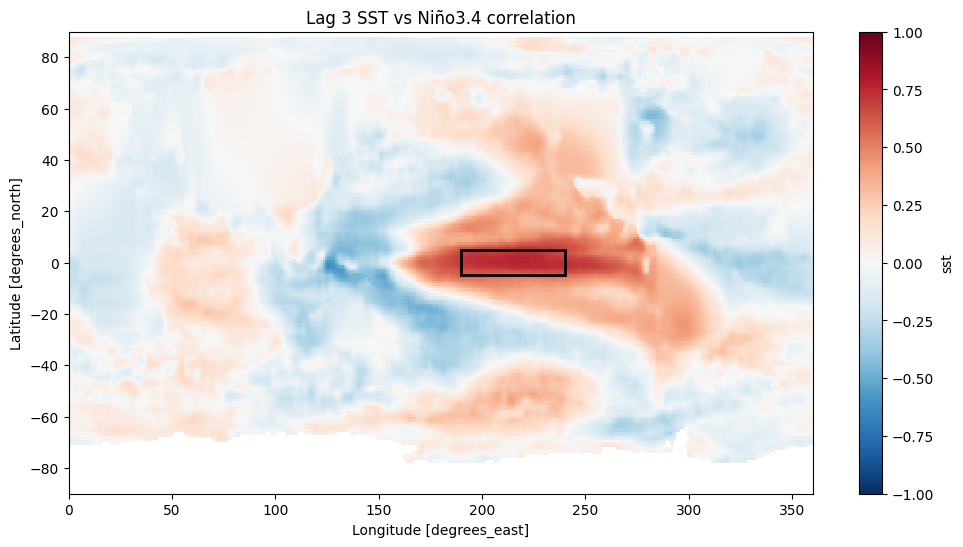

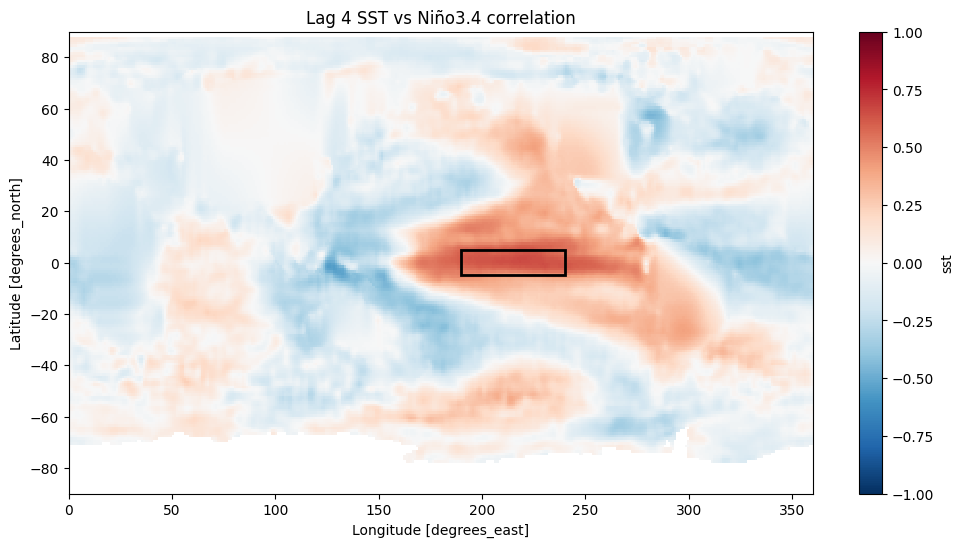

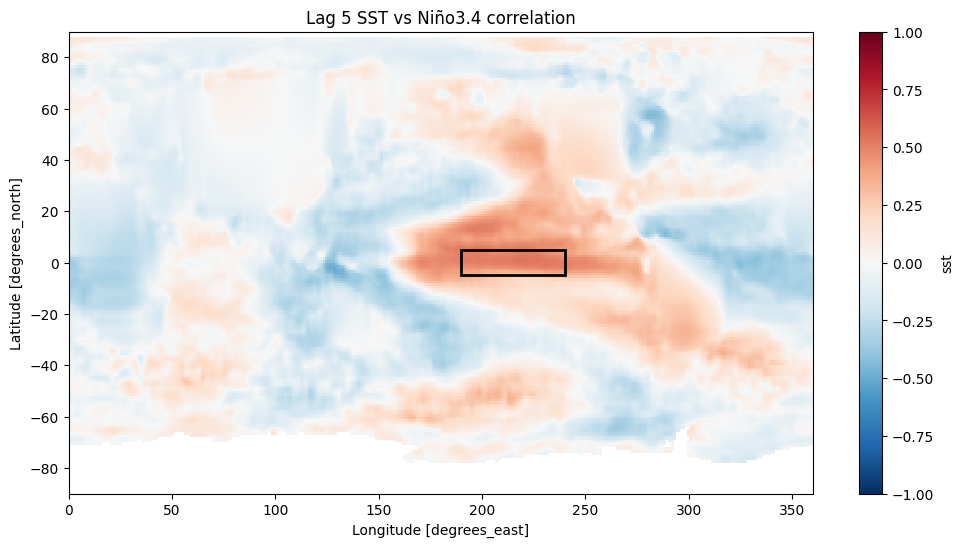

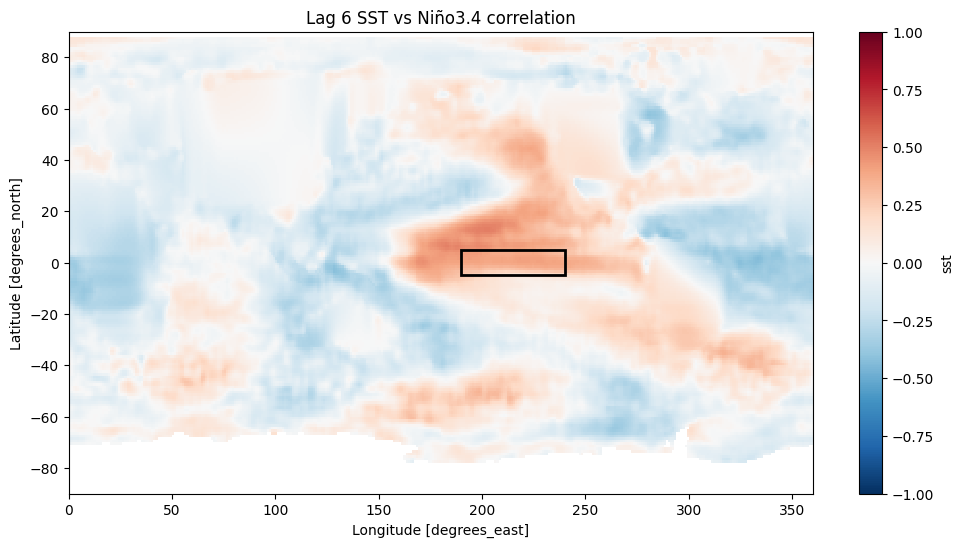

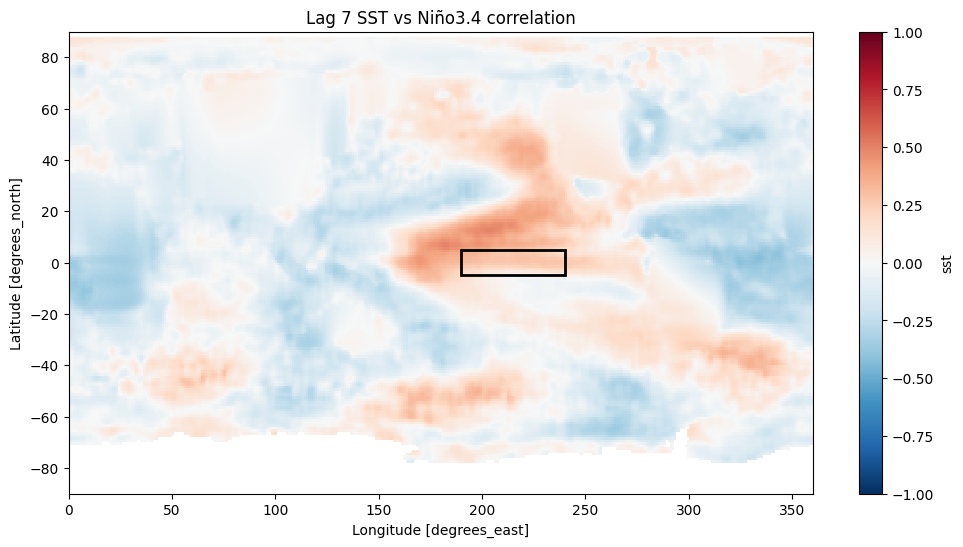

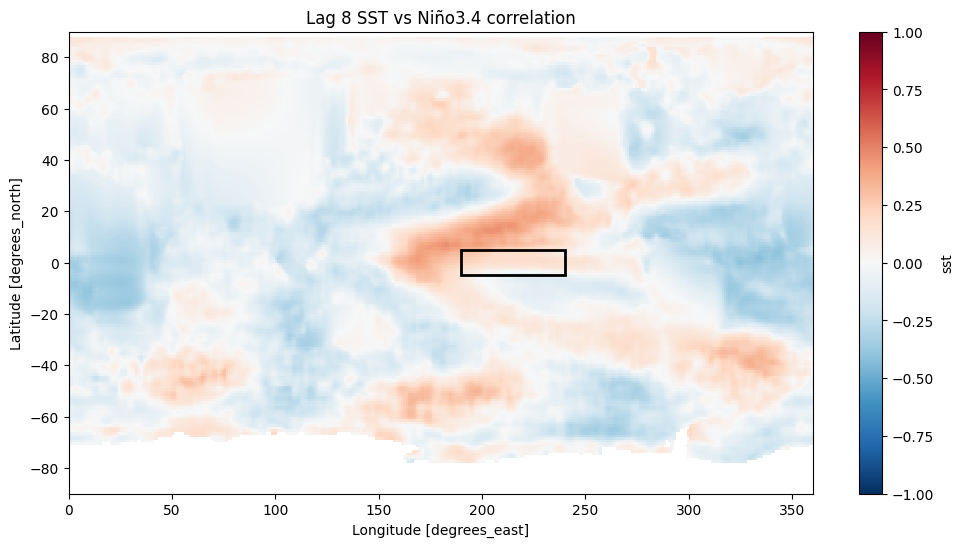

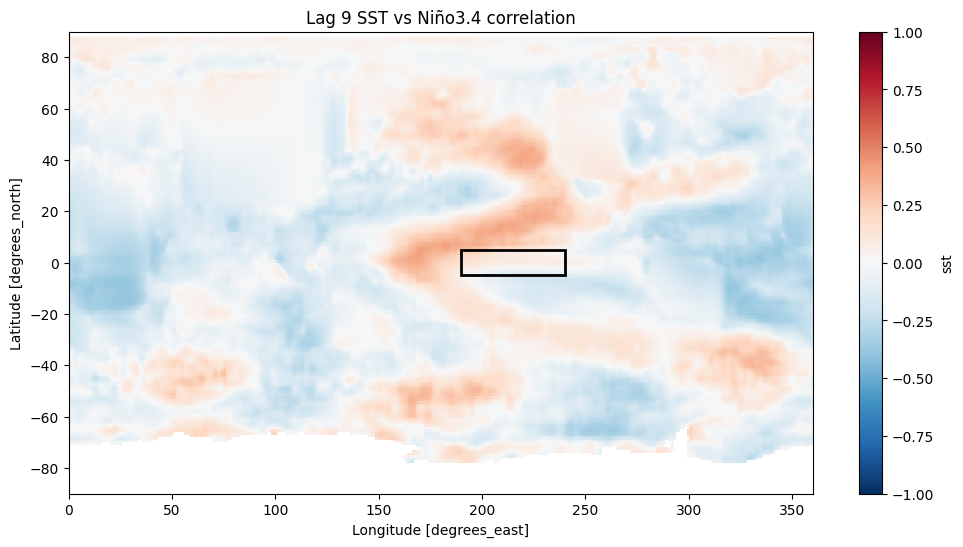

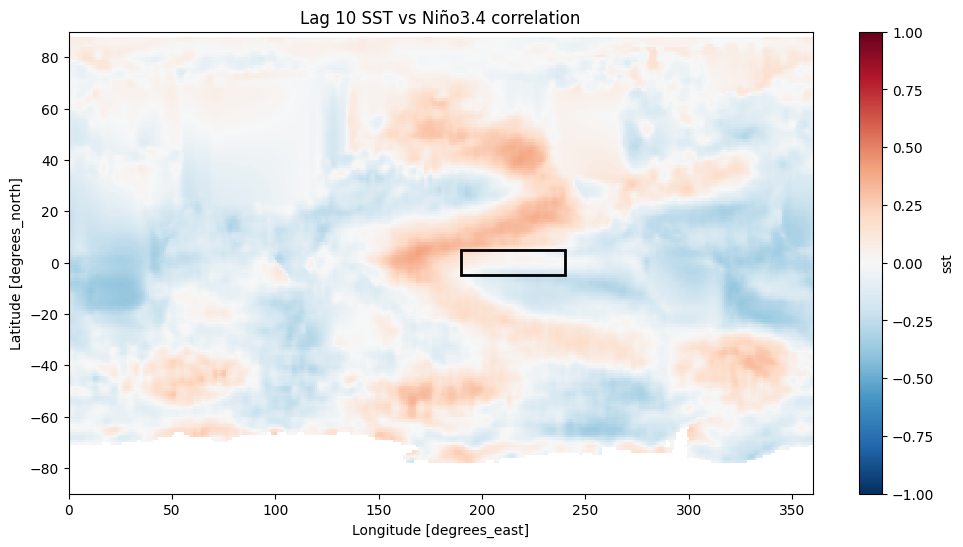

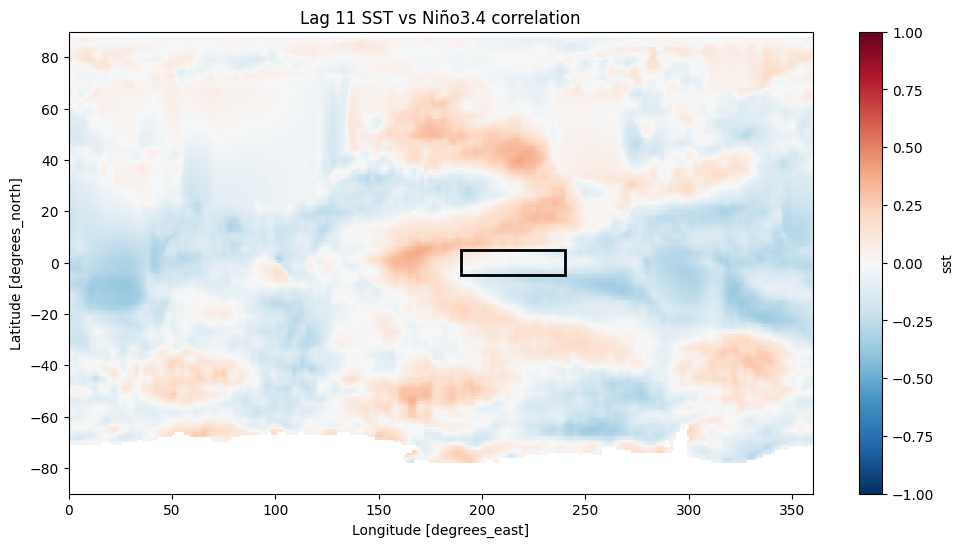

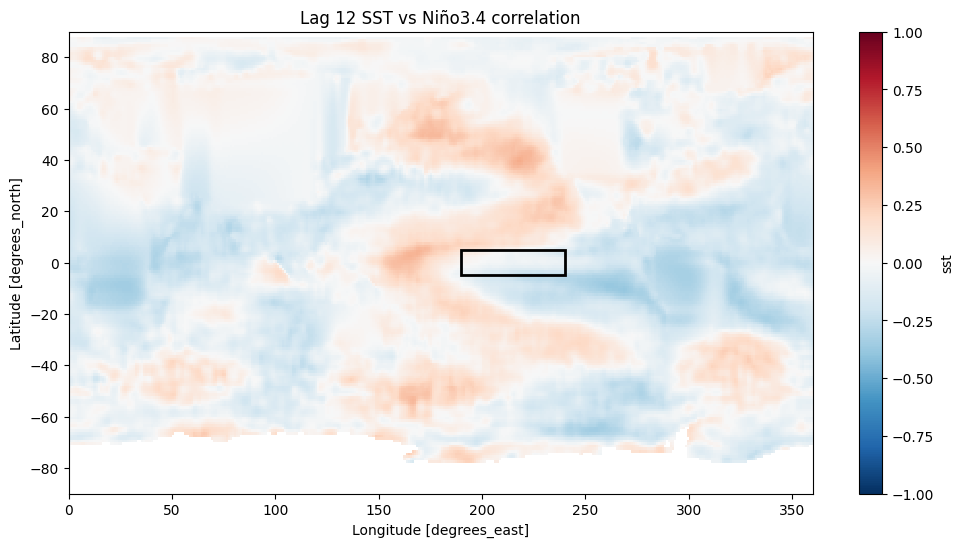

In [112]:
# Niño 3.4 bounds
lat_min, lat_max = -5, 5
lon_min, lon_max = 190, 240

for lag in range(13):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    lag_corr[lag].plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    
    rect = patches.Rectangle((lon_min, lat_min),lon_max - lon_min,lat_max - lat_min,linewidth=2,edgecolor='black',facecolor='none')
    ax.add_patch(rect)
    
    ax.set_title(f"Lag {lag} SST vs Niño3.4 correlation")
    plt.show()

### Global SST anomalies vs. SOI (3-month moving average)

In [113]:
max_lag = 12
lag_corr = []

for lag in range(max_lag+1):
    soi_shifted = soi_3mo.to_xarray().shift(time=-lag)
    corr = xr.corr(sst_anom['sst'], soi_shifted, dim='time')
    lag_corr.append(corr)

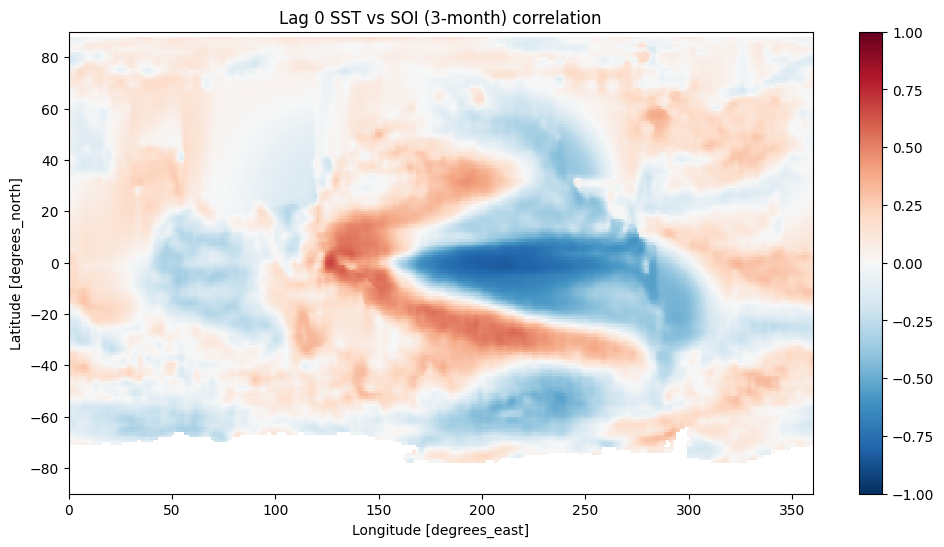

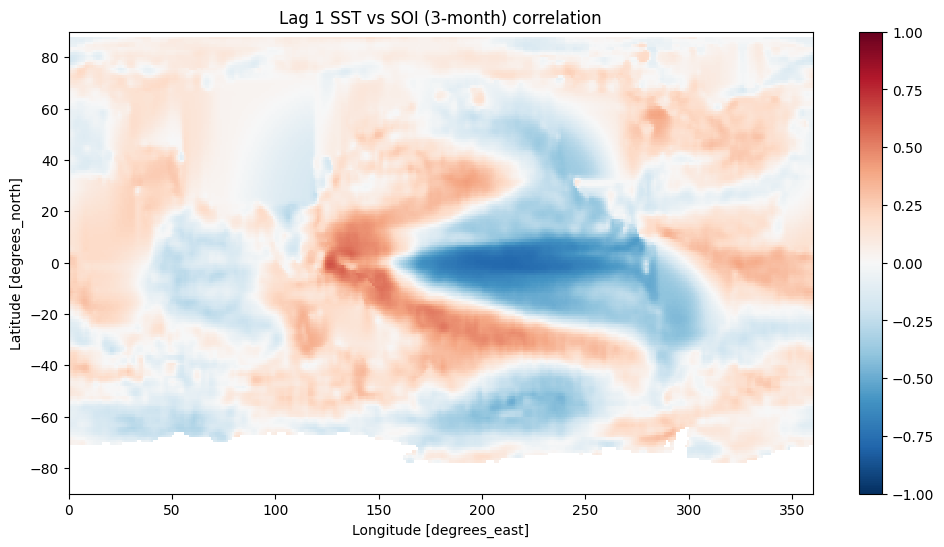

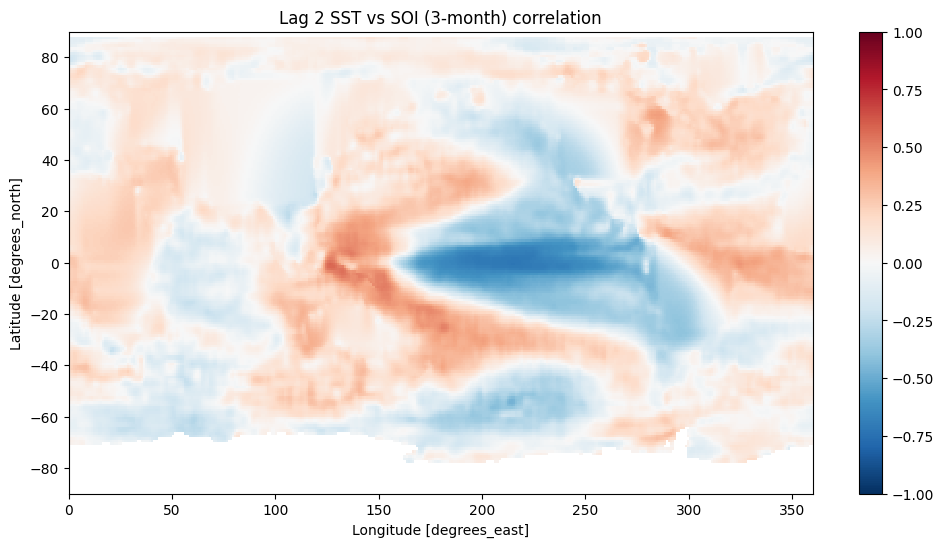

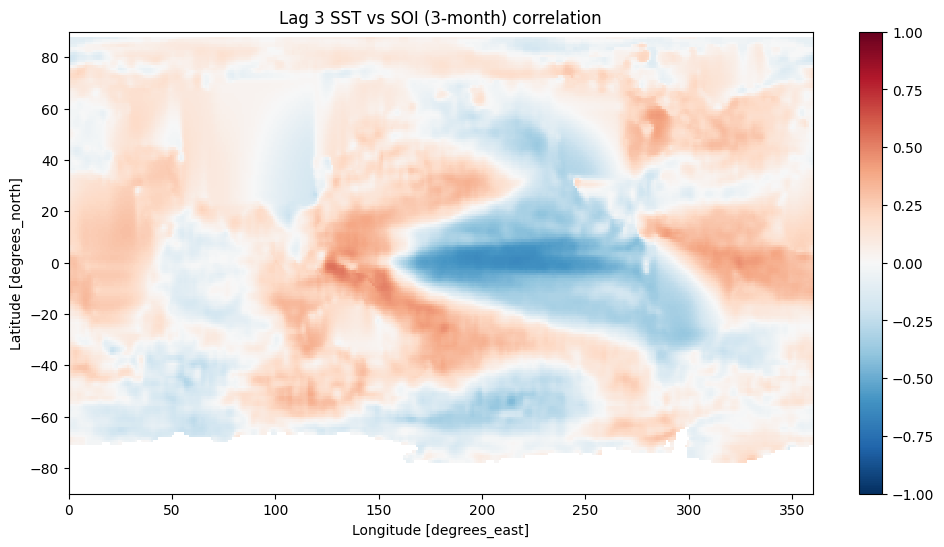

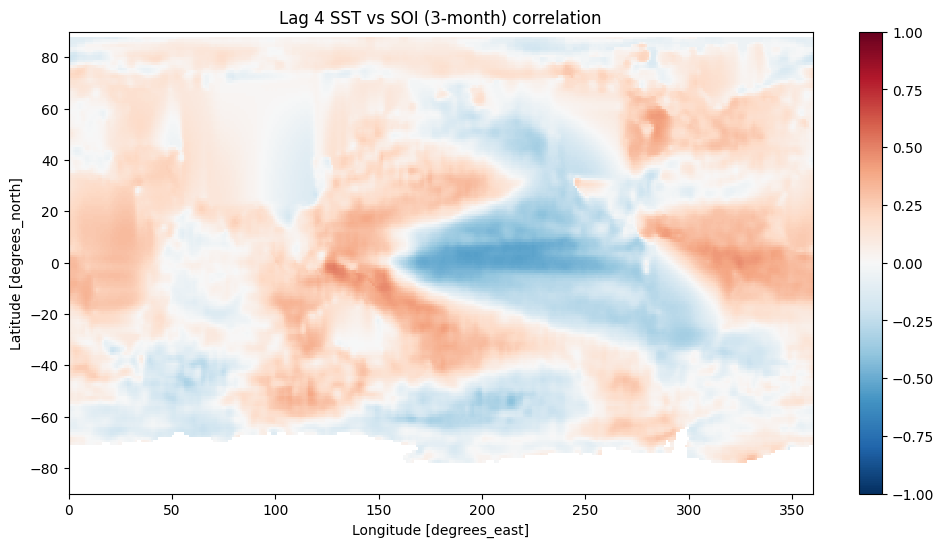

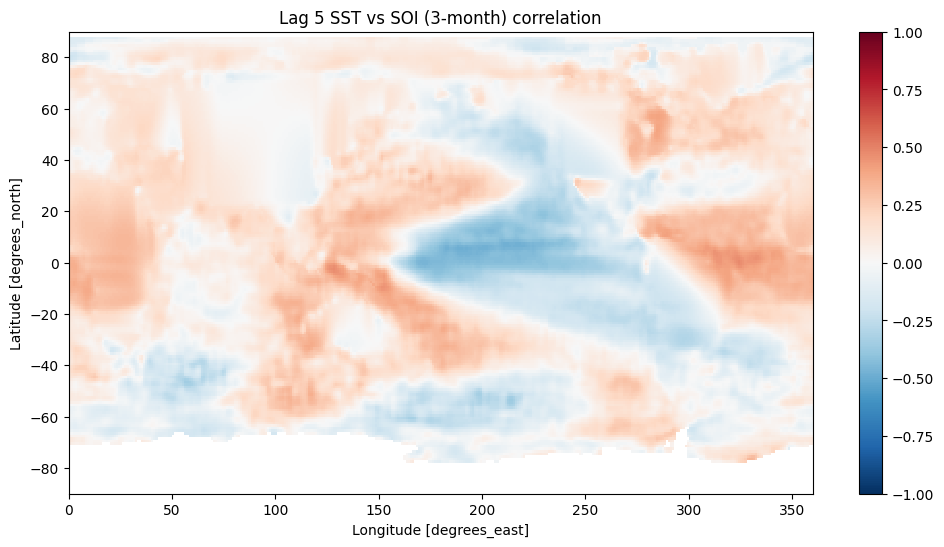

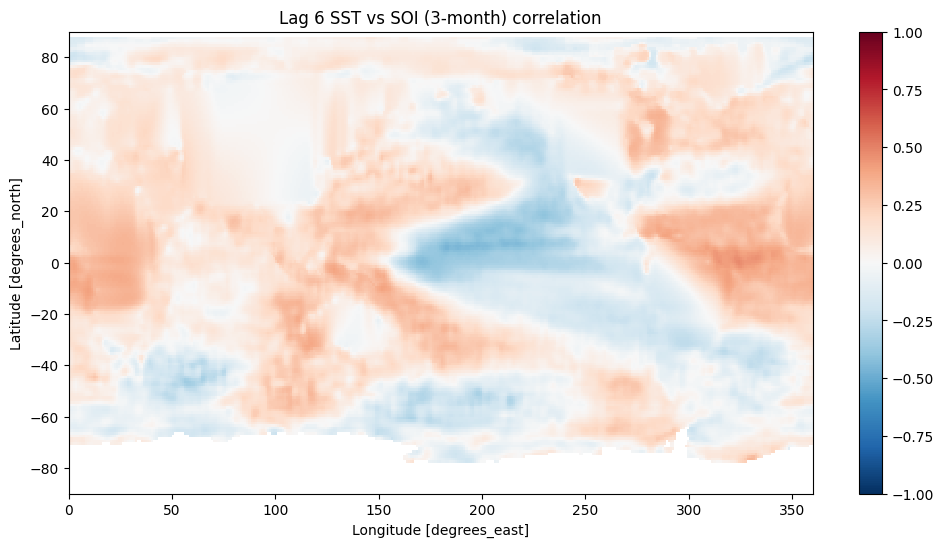

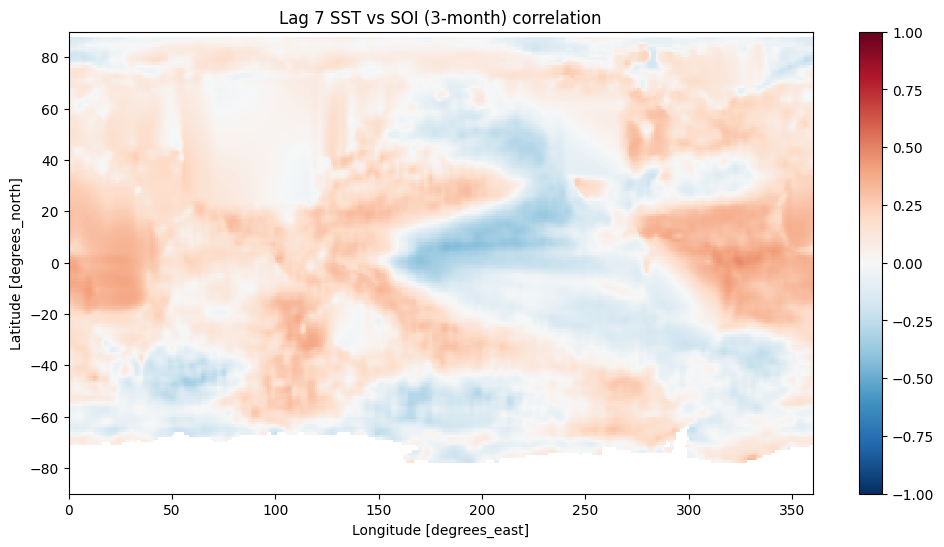

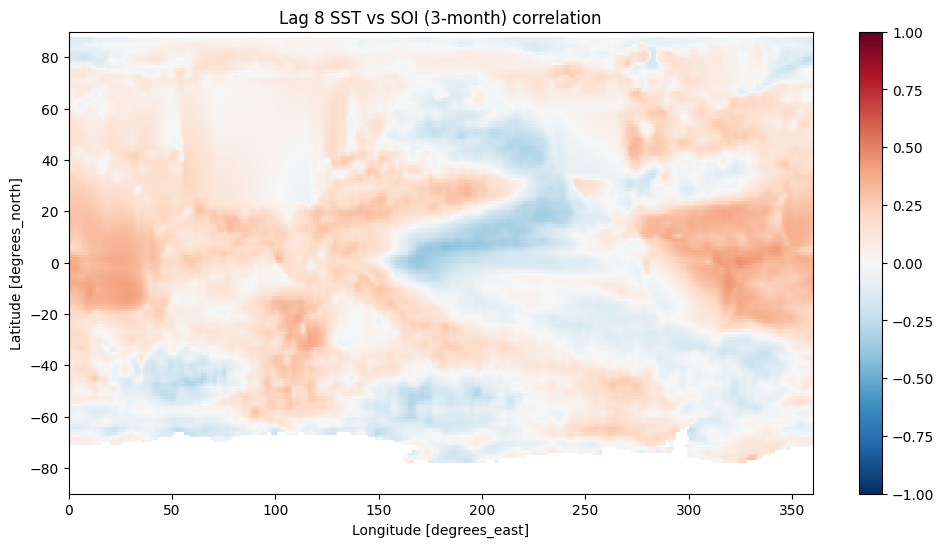

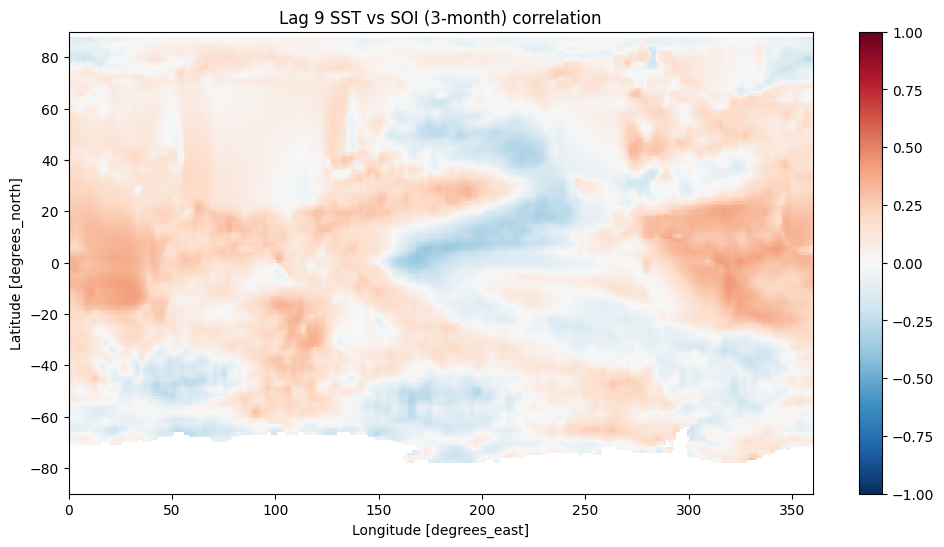

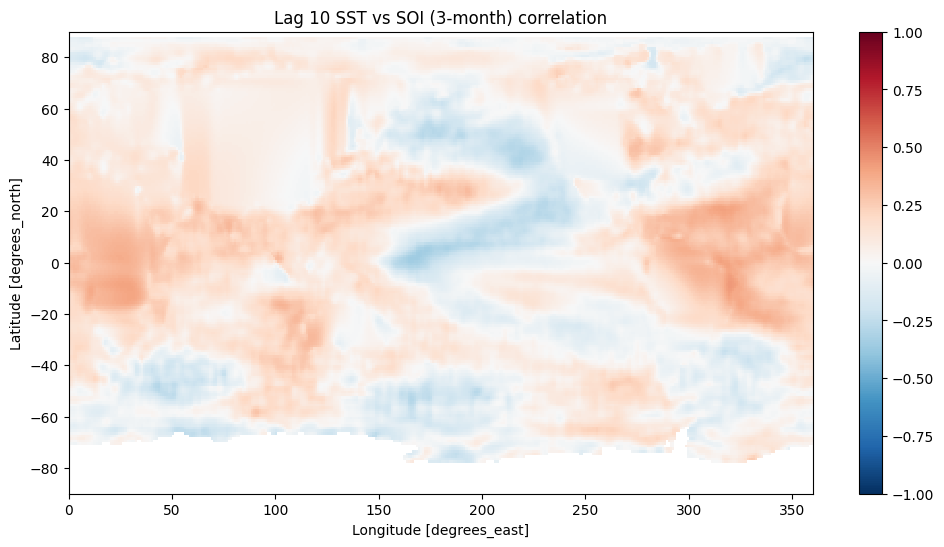

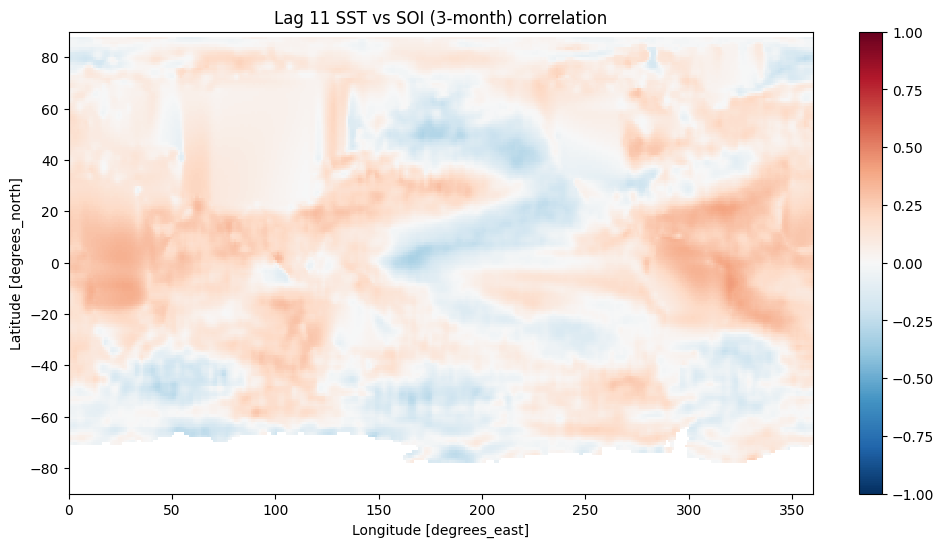

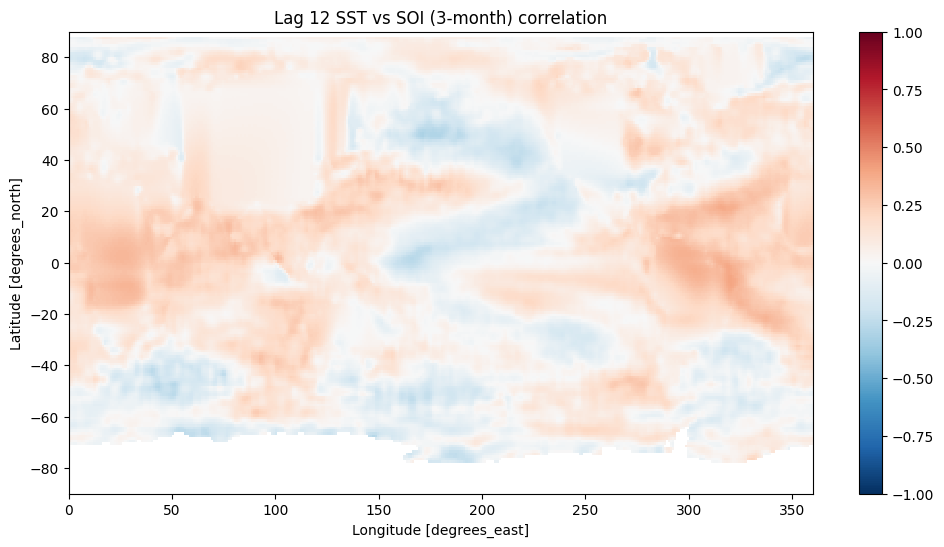

In [114]:
for lag in range(13):
    fig, ax = plt.subplots(figsize=(12, 6))
    lag_corr[lag].plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    
    ax.set_title(f"Lag {lag} SST vs SOI (3-month) correlation")
    plt.show()

### Global MSLP anomalies vs. Niño 3.4

Here we can verify the Southern Oscillation / Walker circulation pattern in pressure space. We visually observe that pression tends to be low during El Niño in the region where SST gets warmer.

In [115]:
max_lag = 12
lag_corr = []

for lag in range(max_lag+1):
    n34_shifted = nino_34_anom.shift(time=-lag)
    corr = xr.corr(mslp_anom['msl'], n34_shifted, dim='time')
    lag_corr.append(corr)

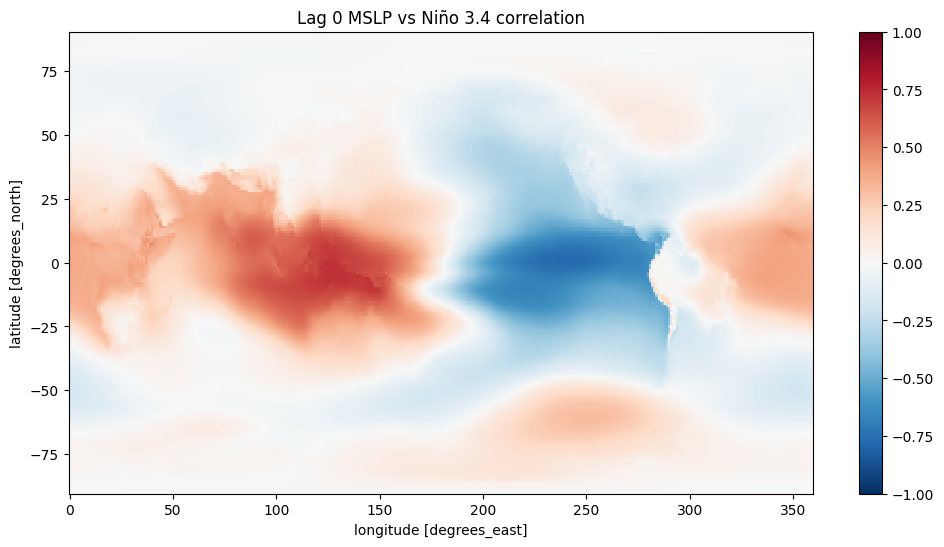

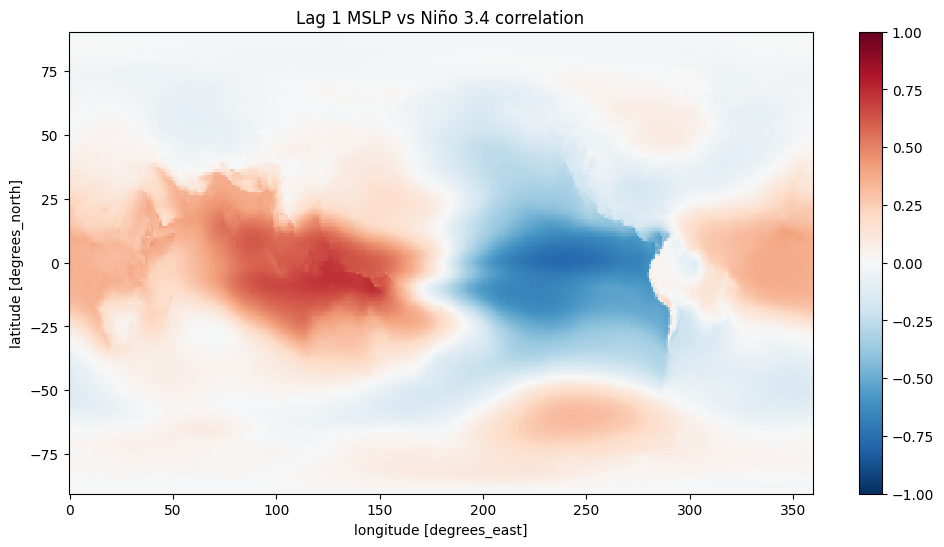

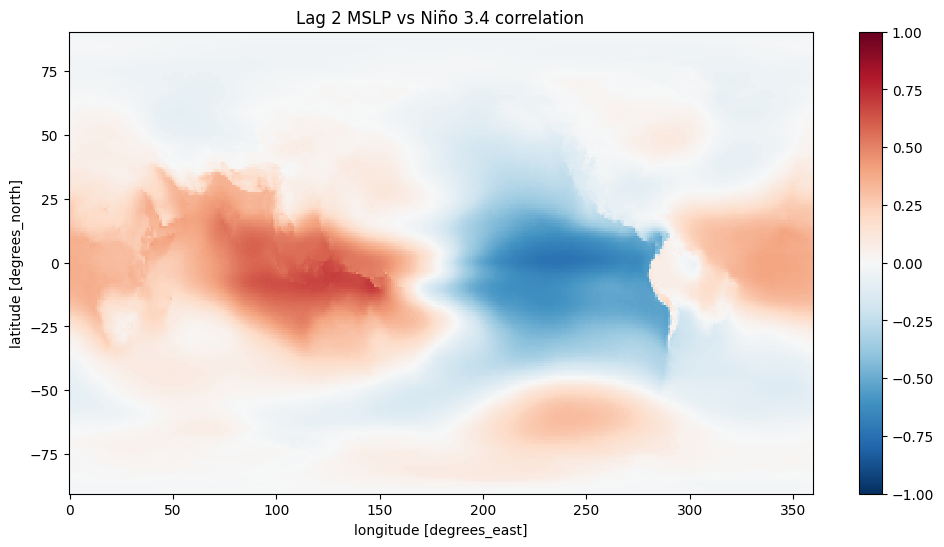

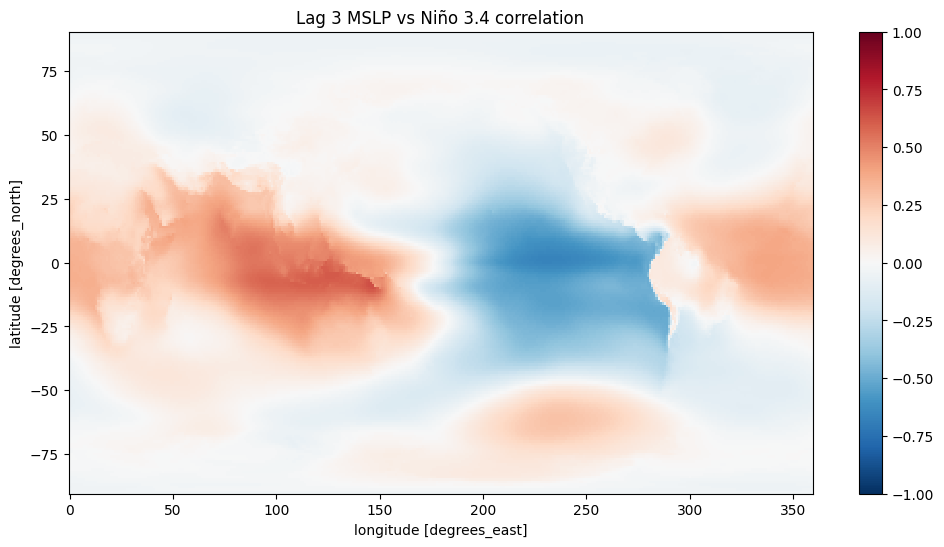

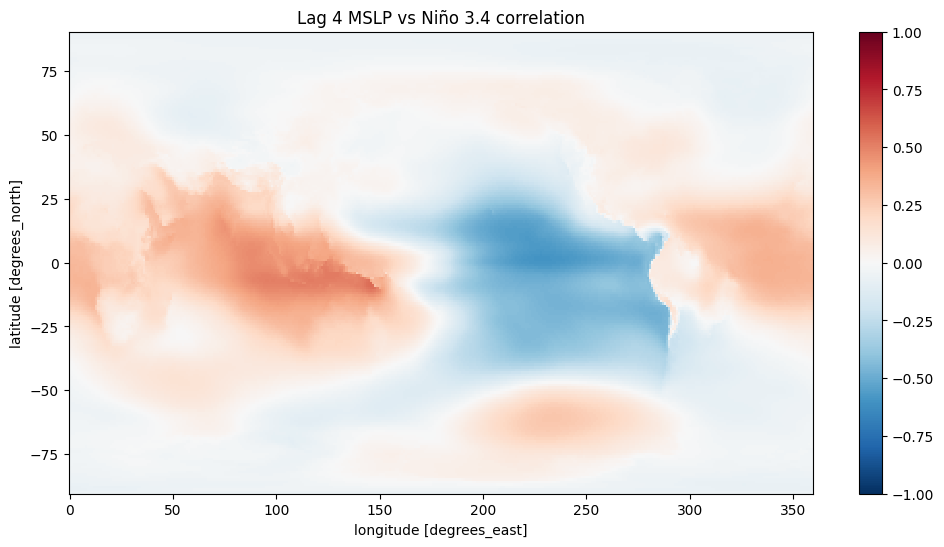

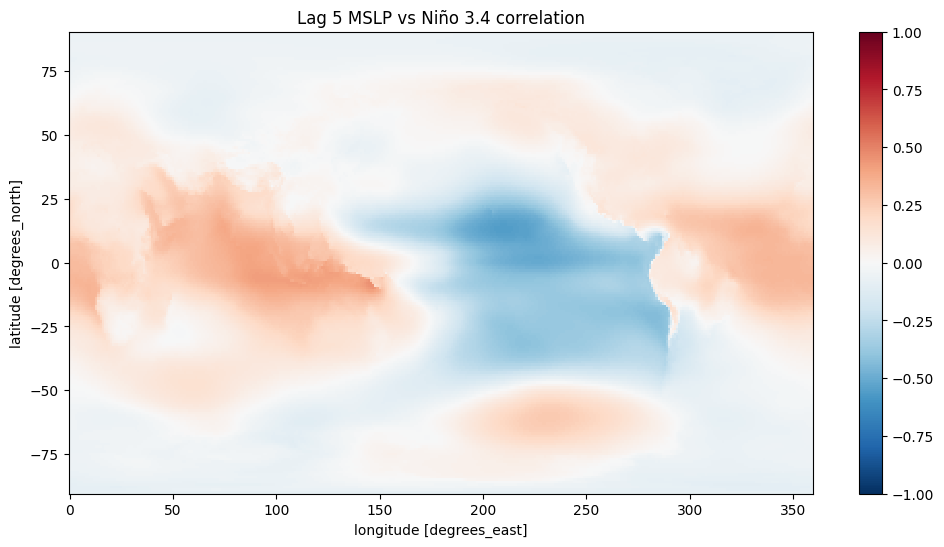

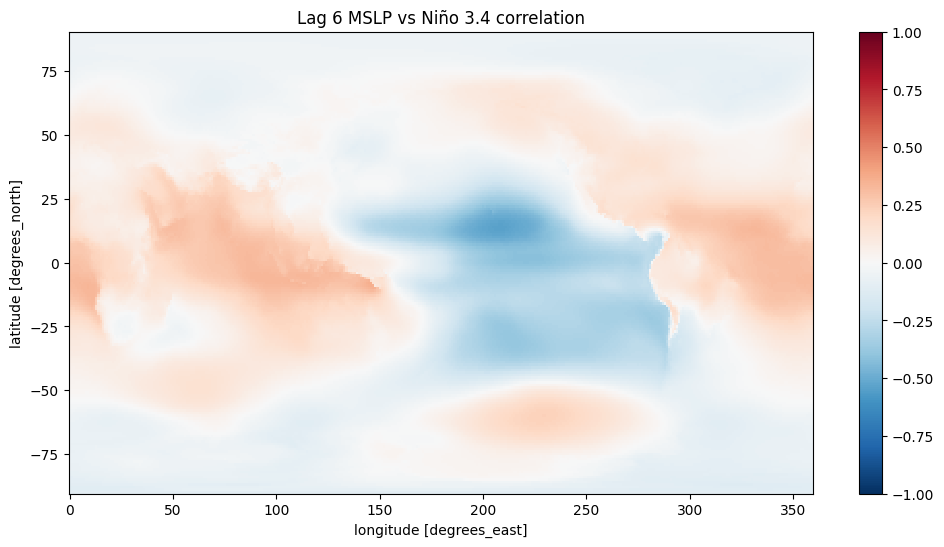

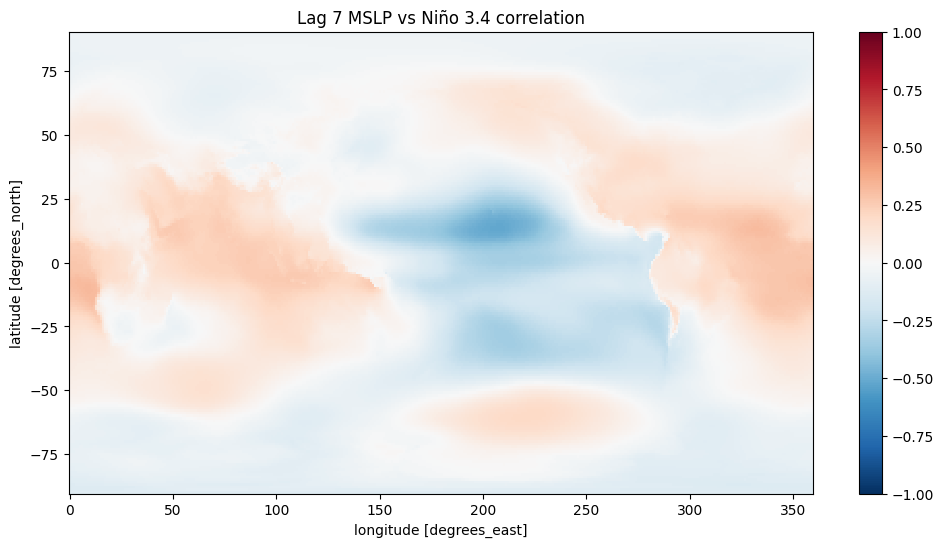

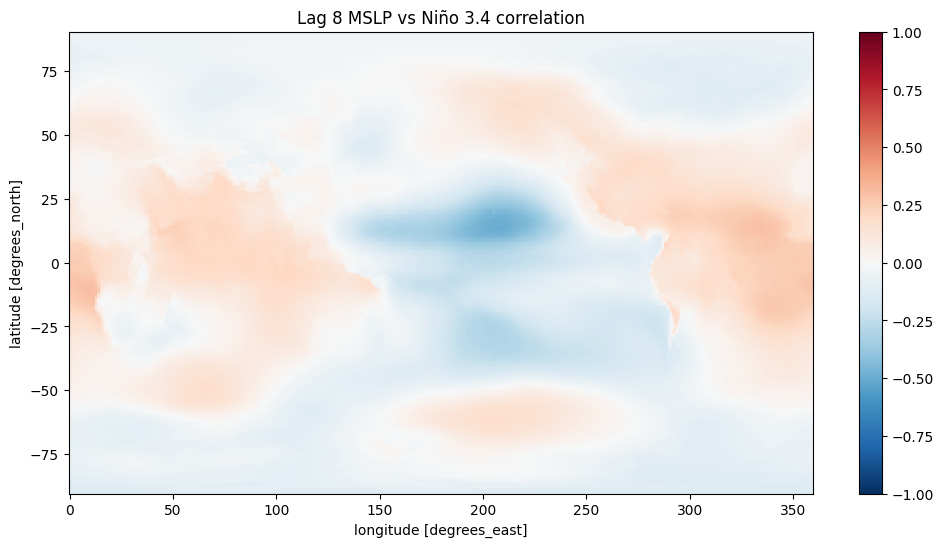

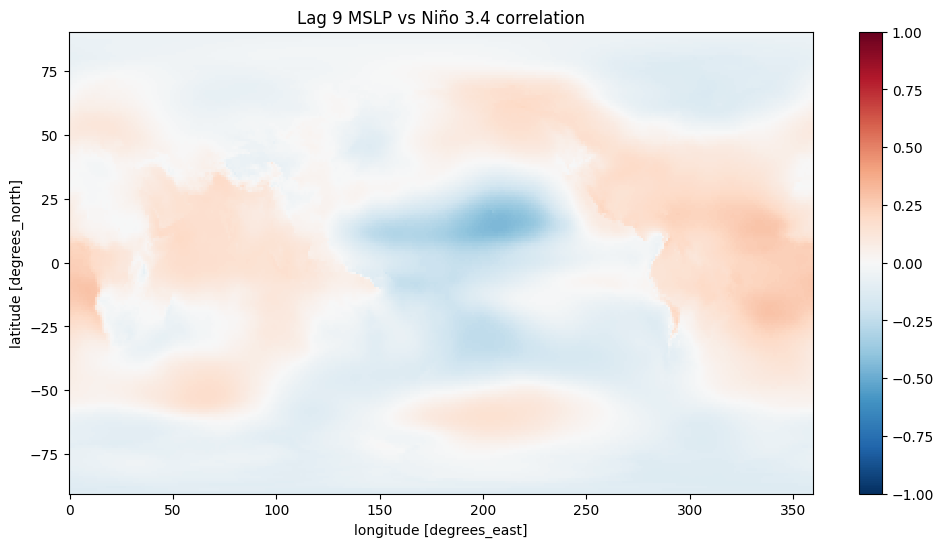

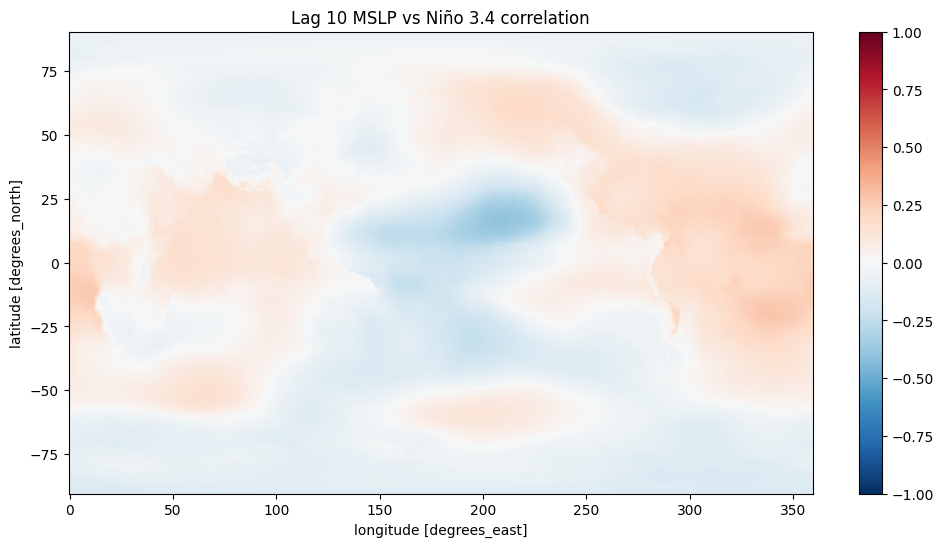

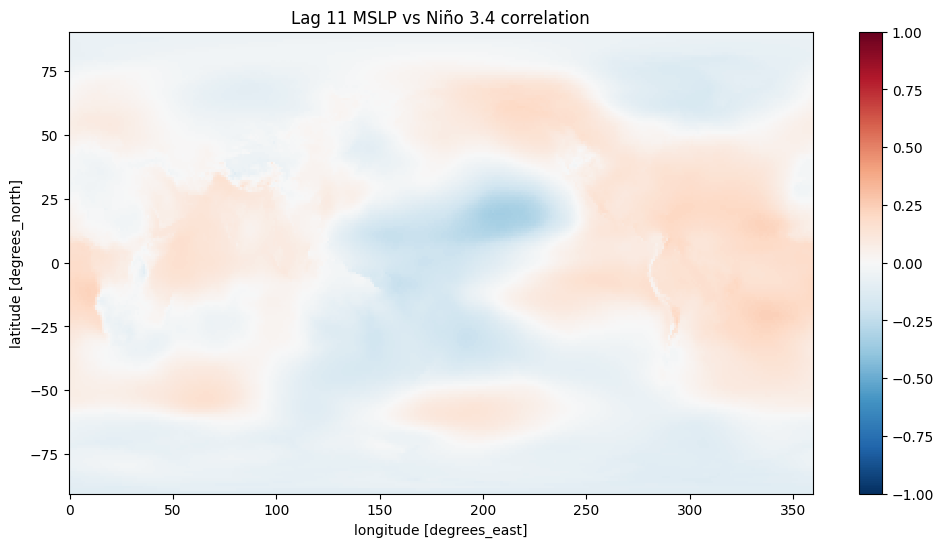

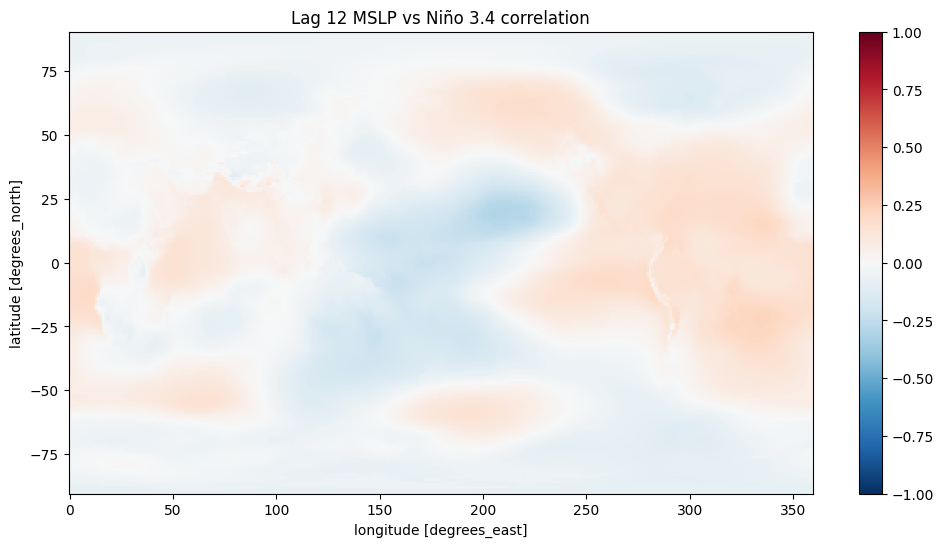

In [116]:
for lag in range(13):
    fig, ax = plt.subplots(figsize=(12, 6))
    lag_corr[lag].plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    
    ax.set_title(f"Lag {lag} MSLP vs Niño 3.4 correlation")
    plt.show()

### Global MSLP anomalies vs. SOI (3-month moving average)

In [117]:
max_lag = 12
lag_corr = []

for lag in range(max_lag+1):
    soi_shifted = soi_3mo.to_xarray().shift(time=-lag)
    corr = xr.corr(mslp_anom['msl'], soi_shifted, dim='time')
    lag_corr.append(corr)

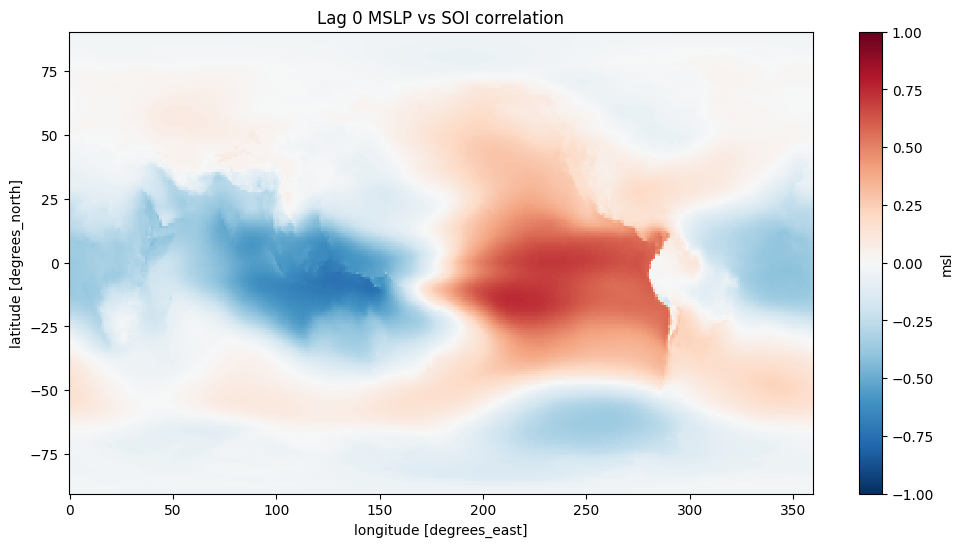

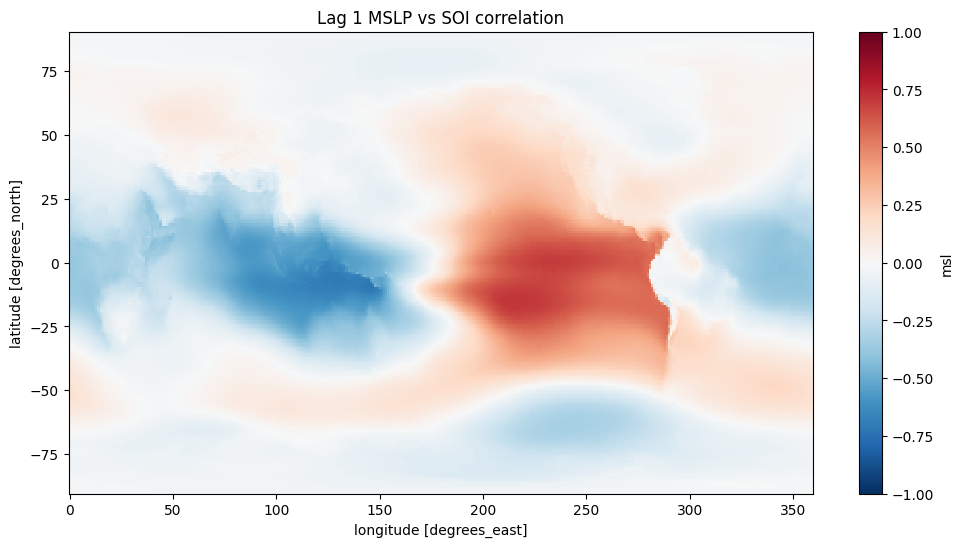

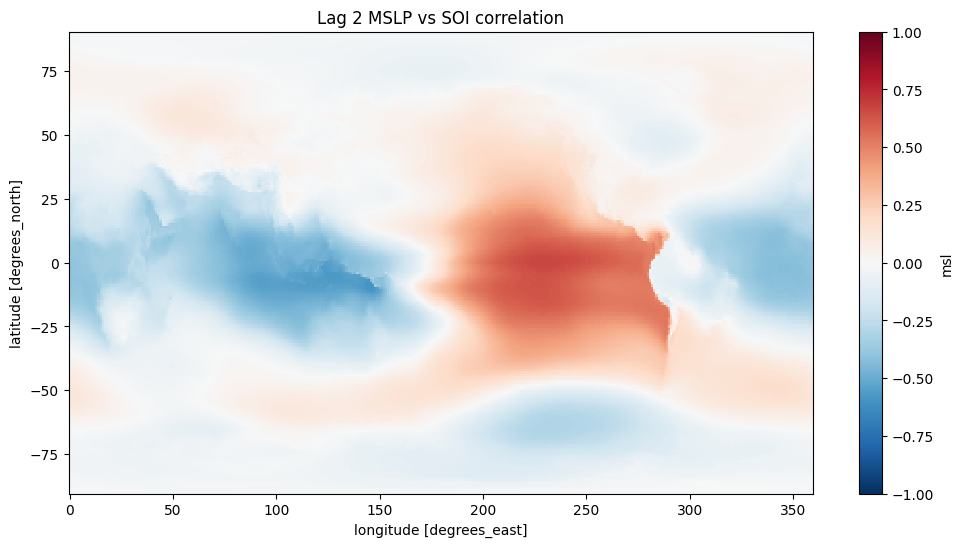

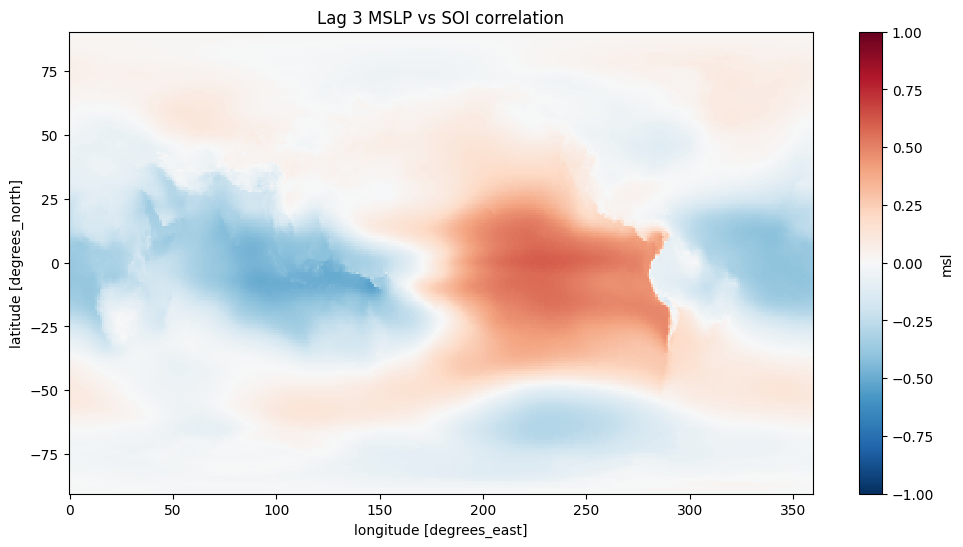

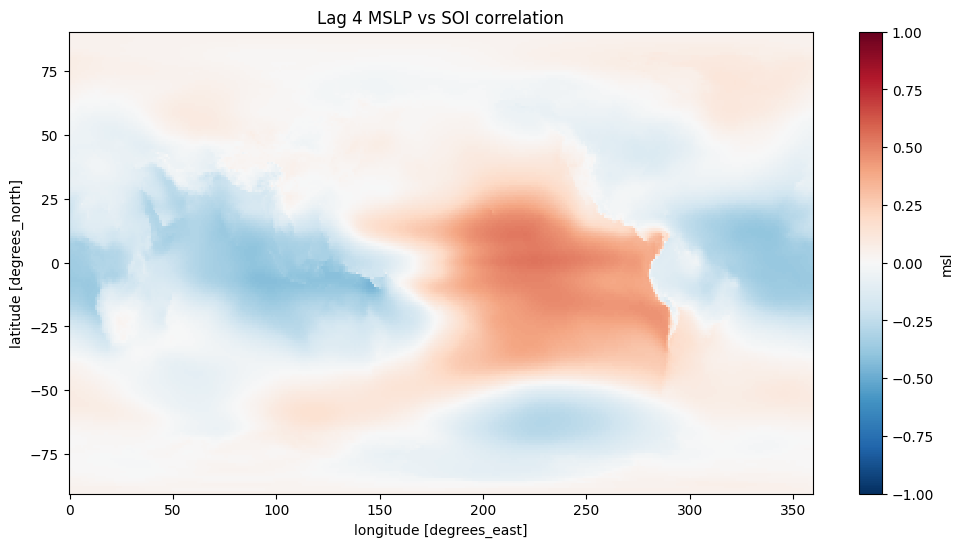

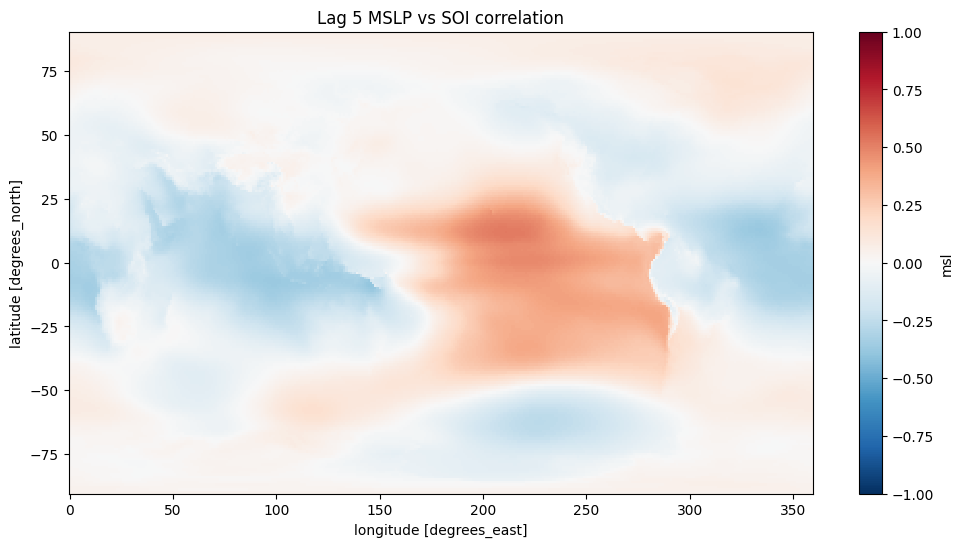

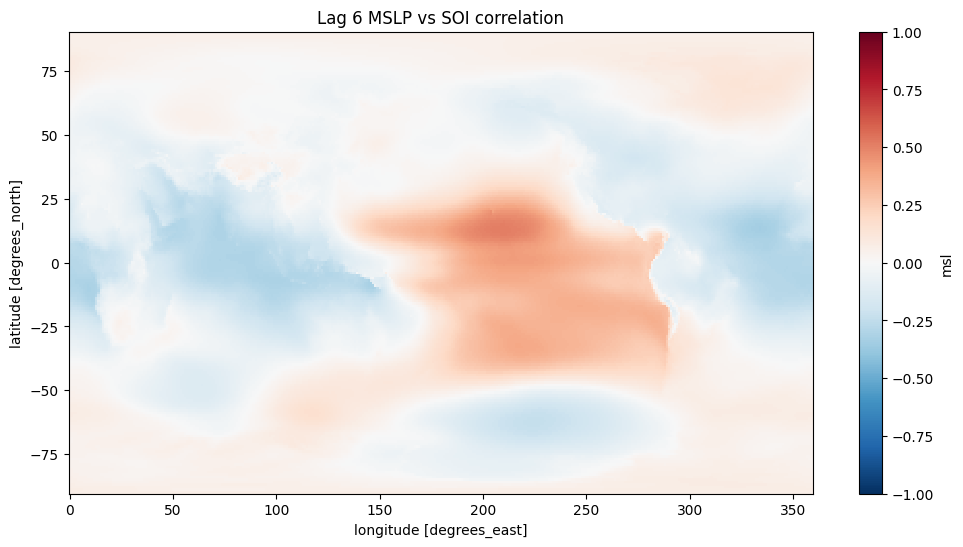

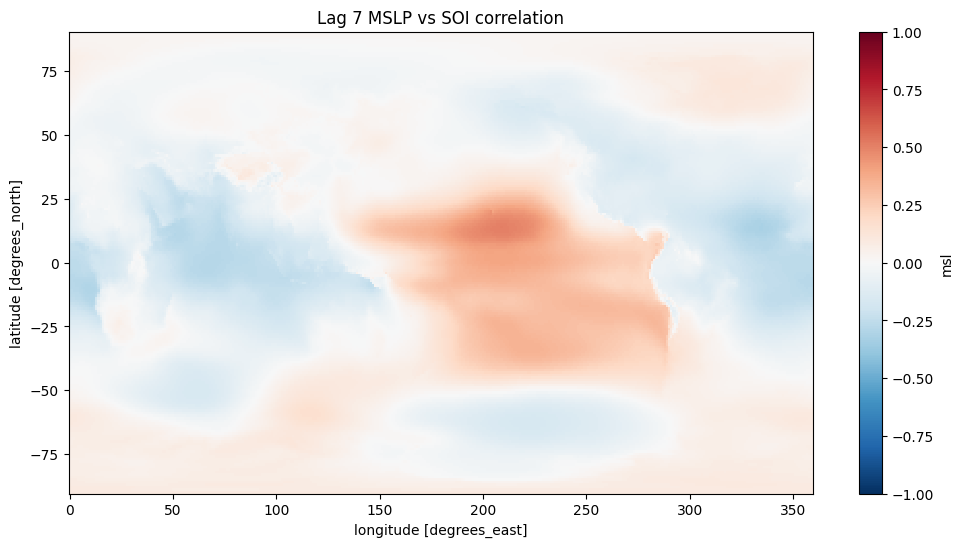

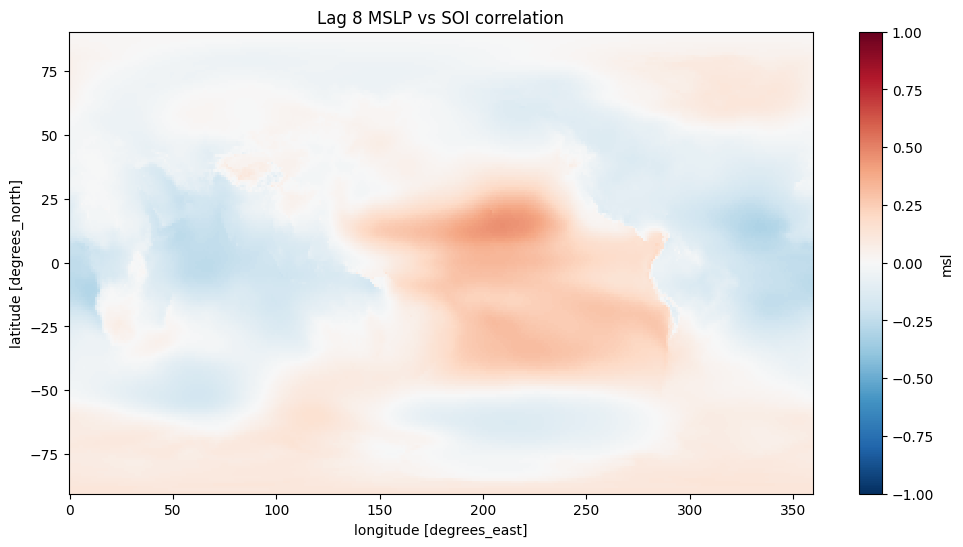

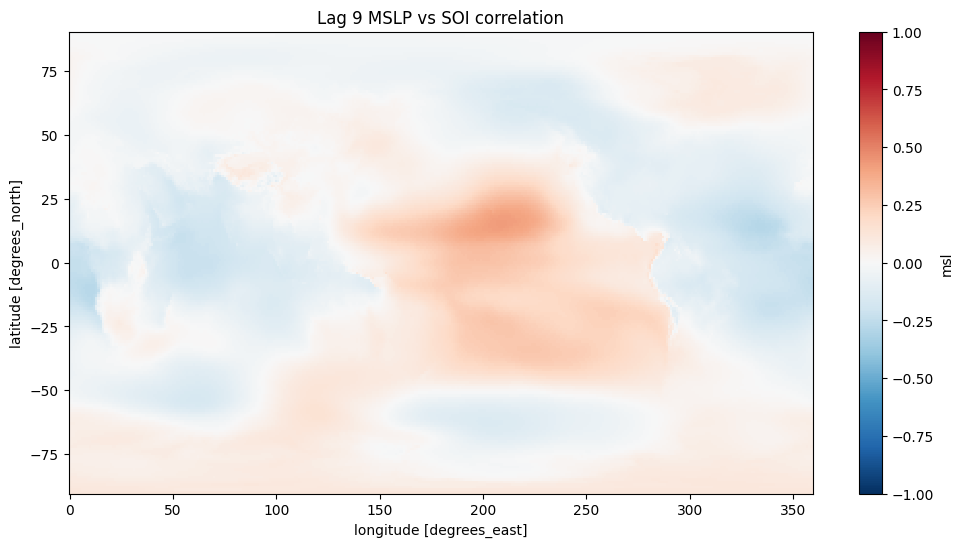

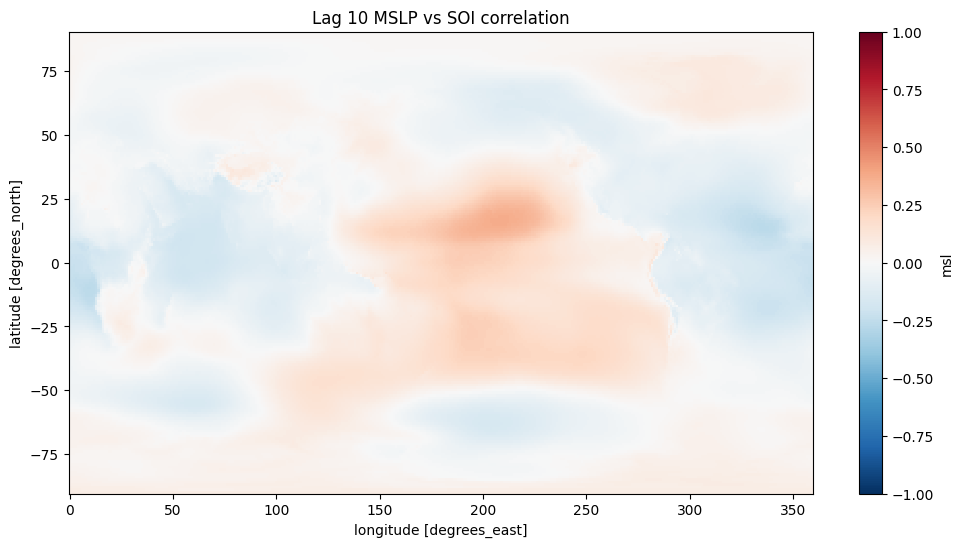

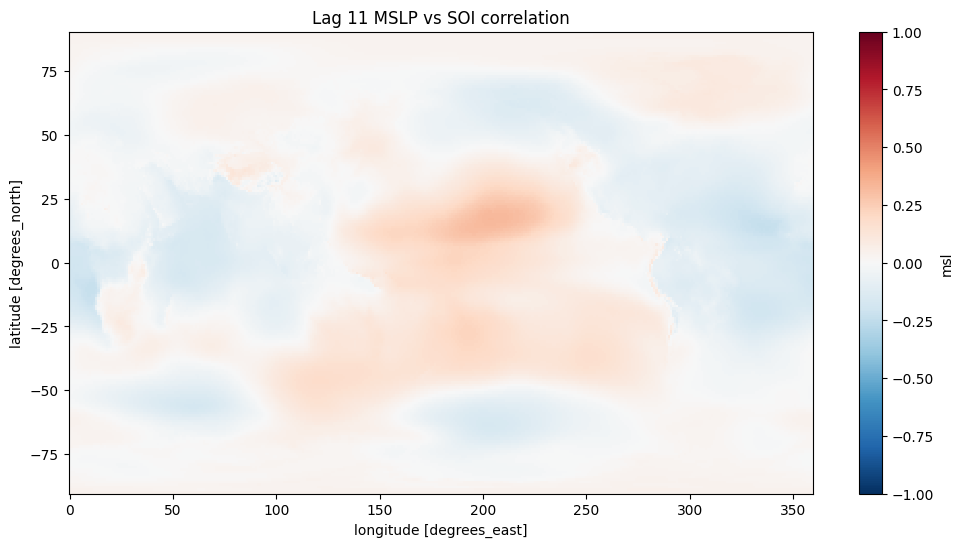

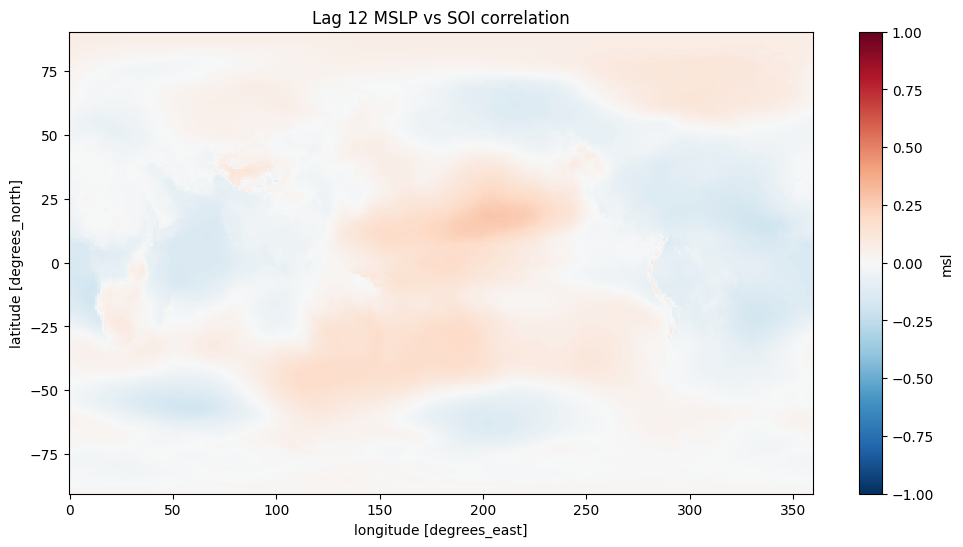

In [118]:
for lag in range(13):
    fig, ax = plt.subplots(figsize=(12, 6))
    lag_corr[lag].plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    
    ax.set_title(f"Lag {lag} MSLP vs SOI correlation")
    plt.show()

# Prediction
Given the limited number of observations (~ 500 per dataset), we avoid using highly complex models such as CNNs or LSTMs for time series forecasting. Instead, we focus on classical regression-based approaches.

## Feature Engineering

We will run a Ridge-Regression model for a horizon of h=3. This means we will try to predict the Niño 3.4 index at 3 months in the future.

**Features**

- Autoregressive Niño3.4 lags (this is usually the #1 signal): lags 0–12
- SOI lags (atmospheric coupling): lags 0–6 (or 0–12)
- SST EOF PCs from your SST field (large-scale patterns beyond Niño3.4): PC1–PC5, lags 0–6
- MSLP EOF PCs
- (not for now) Seasonality encoding (since you’re not smoothing): month-of-year as sin/cos

In [120]:
df = pd.DataFrame(index=nino_34_anom.time.to_series().index)

# target related and atmospheric variables
df['nino34'] = nino_34_anom.to_series()
df['nino3']  = nino_3_anom.to_series()
df['soi']    = soi
df['soi_3m'] = soi_3mo

# projected PCs over full period
df['sst_pc1'] = pc_all_sst[:,0].to_series()
df['sst_pc2'] = pc_all_sst[:,1].to_series()
df['mslp_pc1'] = pc_all_mslp[:,0].to_series()
df['mslp_pc2'] = pc_all_mslp[:,1].to_series()

# lags 
for lag in [1,3,6]: 
    df[f'nino34_lag{lag}'] = df['nino34'].shift(lag)
    df[f'nino3_lag{lag}'] = df['nino3'].shift(lag)

for lag in [3, 6]:
    df[f'sst_pc1_lag{lag}'] = df['sst_pc1'].shift(lag)

for lag in [0, 1, 3]: # mslp has shorter memory
    df[f'soi_lag{lag}'] = df['soi'].shift(lag)

for lag in [0, 1]: # walker circulation is fast
    df[f'mslp_pc1_lag{lag}'] = df['mslp_pc1'].shift(lag)

# seasonality
df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
df['month_cos'] = np.cos(2*np.pi*df.index.month/12)

## Linear Regression

In [144]:
# for linear regression we combine val and test slices
combined_slice = slice(val_slice.start, test_slice.stop)

In [148]:
def run_ols_single_lead(df_ml, df_flags, LEAD, train_slice, val_slice, test_slice):

    combined_slice = slice(val_slice.start, test_slice.stop)

    y = df_ml['nino34'].shift(-LEAD)
    X = df_ml.drop(columns=['target'], errors='ignore')

    data = pd.concat([X, y.rename('target')], axis=1).dropna()
    X, y = data.drop(columns='target'), data['target']

    X_train = X.loc[train_slice]
    y_train = y.loc[train_slice]
    X_test  = X.loc[combined_slice]
    y_test  = y.loc[combined_slice]

    ols = LinearRegression()
    ols.fit(X_train, y_train)
    y_pred = ols.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    corr = np.corrcoef(y_test, y_pred)[0, 1]

    plot_index = y_test.index + pd.DateOffset(months=LEAD)

    return {
        "LEAD": LEAD,
        "y_test": pd.Series(y_test.values, index=plot_index),
        "y_pred": pd.Series(y_pred, index=plot_index),
        "flags": df_flags.loc[plot_index, 'flag'],
        "rmse": rmse,
        "corr": corr
    }


In [151]:
def plot_ols_leads(df_ml, df_flags, leads, train_slice, val_slice, test_slice):
    
    fig, axes = plt.subplots(len(leads), 1, figsize=(15, 15), sharex=True)

    for ax, LEAD in zip(axes, leads):

        res = run_ols_single_lead(df_ml, df_flags, LEAD, train_slice, val_slice, test_slice)

        y_test = res["y_test"]
        y_pred = res["y_pred"]
        flags  = res["flags"]

        ax.plot(y_test.index, y_test, color='black', lw=1.5, linestyle='--', label='Observed')
        ax.plot(y_test.index, y_pred, lw=2, label='Forecast')

        # La Niña and El Niño events
        ax.fill_between(y_test.index, 0, 1, where=(flags == 2), transform=ax.get_xaxis_transform(), color='red', alpha=0.15)
        ax.fill_between(y_test.index, 0, 1, where=(flags == 1), transform=ax.get_xaxis_transform(), color='blue', alpha=0.15)

        ax.axhline(0, color='gray', lw=0.8)
        ax.set_title(f"Lead = {LEAD} months\nRMSE={res['rmse']:.2f}, r={res['corr']:.2f}")
        ax.grid(alpha=0.3)

    axes[0].legend(loc='upper right')
    fig.suptitle("Niño-3.4 OLS forecasts at different lead times", fontsize=14)
    plt.tight_layout()
    plt.show()

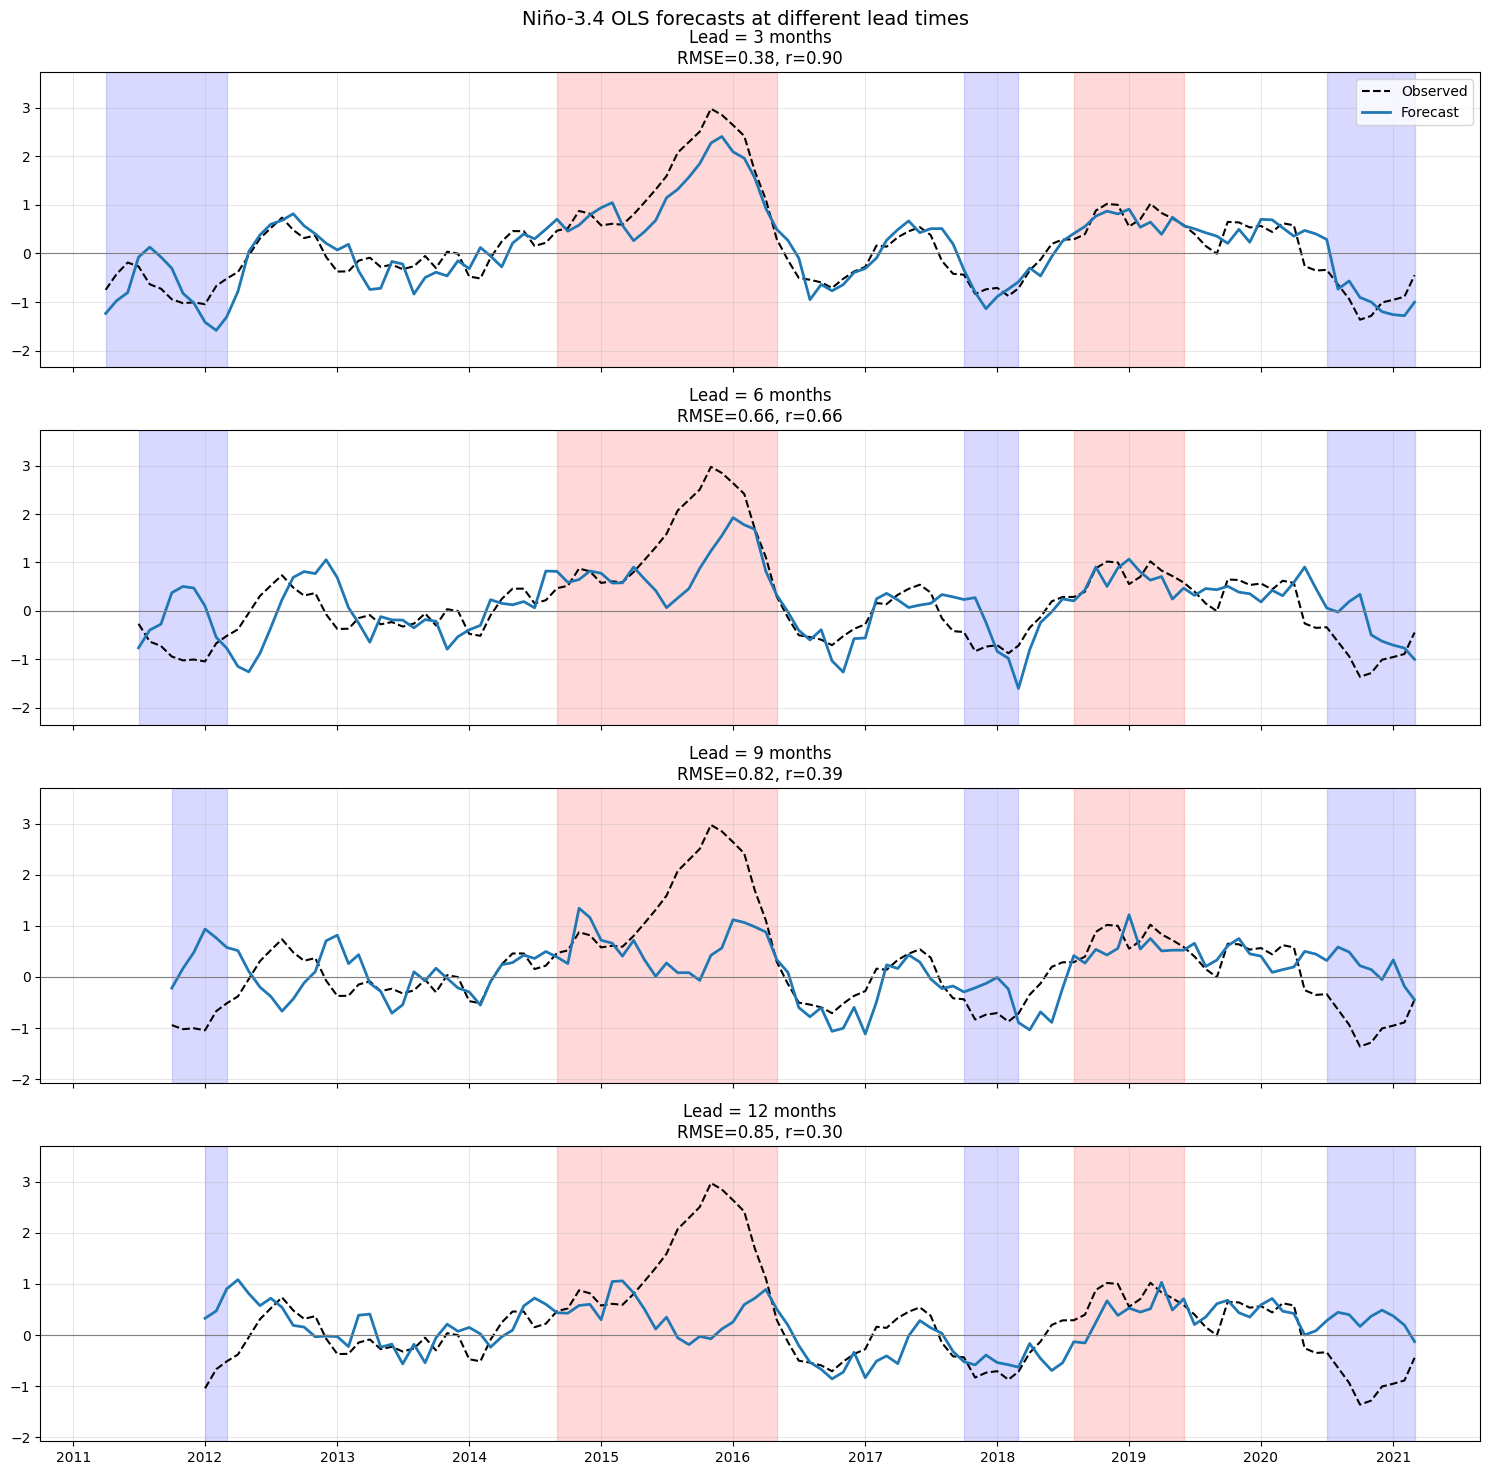

In [152]:
plot_ols_leads(
    df_ml=df_ml,
    df_flags=df_nino34,
    leads=[3, 6, 9, 12],
    train_slice=train_slice,
    val_slice=val_slice,
    test_slice=test_slice
)

## Ridge Regression

In [177]:
# we go back to the original test slices
X_test  = X.loc[test_slice]
y_test  = y.loc[test_slice]

In [178]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)

y_pred_test_ridge = ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))
corr_ridge = np.corrcoef(y_test, y_pred_test_ridge)[0, 1]

print(f"Ridge RMSE (test): {rmse_ridge:.3f}")
print(f"Ridge correlation (test): {corr_ridge:.2f}")

Ridge RMSE (test): 0.320
Ridge correlation (test): 0.87


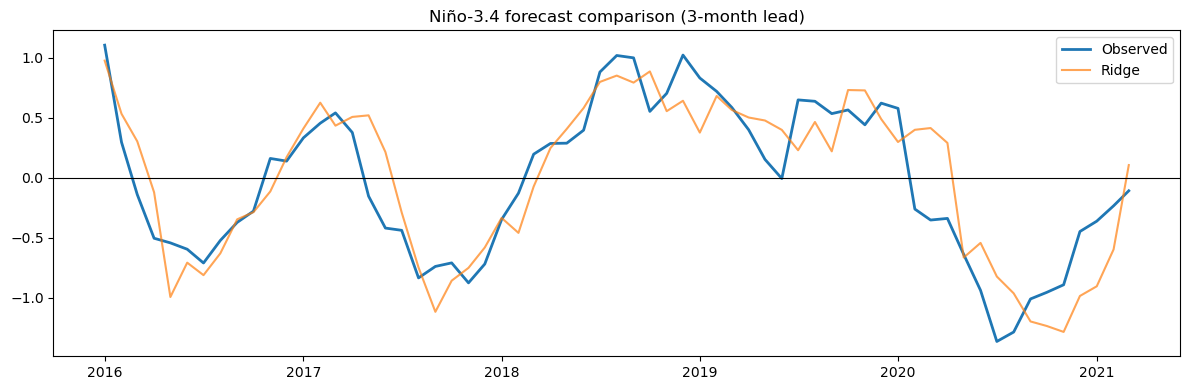

In [183]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test, label='Observed', linewidth=2)
# plt.plot(y_test.index, y_pred_test, label='OLS', alpha=0.7)
plt.plot(y_test.index, y_pred_test_ridge, label='Ridge', alpha=0.7)

plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.title("Niño-3.4 forecast comparison (3-month lead)")
plt.tight_layout()
plt.show()

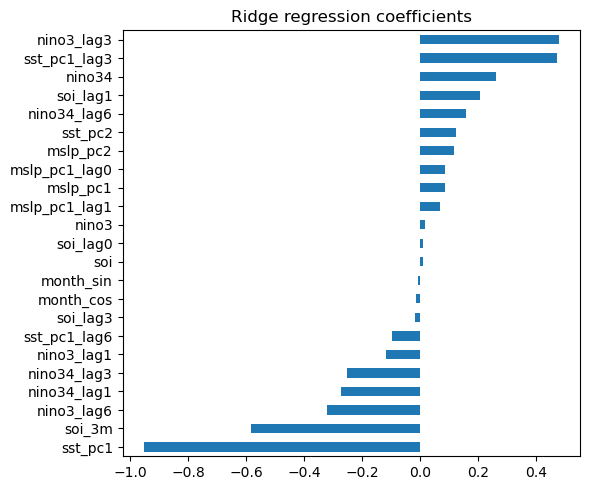

In [180]:
features = [c for c in df_ml.columns if c != 'target']

coef = ridge.named_steps['ridge'].coef_
coef_df = pd.Series(coef, index=features).sort_values()

plt.figure(figsize=(6, 5))
coef_df.plot.barh()
plt.title("Ridge regression coefficients")
plt.tight_layout()
plt.show()

## Random Forest

# Conclusion

# References

[1] https://journals.ametsoc.org/view/journals/bams/78/12/1520-0477_1997_078_2771_tdoeno_2_0_co_2.pdf

[2] https://www.ncei.noaa.gov/access/monitoring/enso/soi

[3] https://www.bom.gov.au/climate/enso/soi/ 

[4] https://environment.govt.nz/assets/publications/Environmental-Reporting/Atmosphere-and-climate-indcators-2023-updated-datasets.pdf

Further references to explore:

- https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1002/qj.49709139009
- https://www.longpaddock.qld.gov.au/soi/

# Things to explore

feito 1) trend: (1) regressão linear, ver se o R^2 e coeff é relevante o suficiente (p-value) (2) decomposição ARIMA -> importante pra checar se a baseline é válida (n pode ter trend) -> o que fazer se tiver?

feito 2) [Não necessariamente fazer, mas é uma sequencia] PCA em região específica para ver se tem outros index interessantes (se as regiões 3 e 3.4 são as mais explicativas)

3) [paralelo] flag de fenomenos e ver a sazonalidade deles (checar se é possivel)
- lag correlation (delayed oscillator) tanto entre as regiões quanto com a pressão
- flag de fenomenos e ver a sazonalidade deles (checar se é possivel)
- classificação: colocar flags de fenomeno (el nino, la nina, nada) no tempo e ver se tem classificações de SOI (intervalos de valores que sempre batem)


4) seguir análise pra região 1+2?



**todo**
- escrever sobre lag correlation
- passar funçoes de plot pra cima
- prediçao: (1) classificação por flags (2) regressão por index

**apresentacao**
- explicar limitaçoes do OLS, autocorrelation
- saber explicar o conditioning number
- why pc2 not lagged

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>